# Preprocesamiento


In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: Upscale GPU RAM to 24 gb

!nvidia-smi -L
!nvidia-smi -pm 1


GPU 0: Tesla T4 (UUID: GPU-2d508704-46ed-ab5f-d04c-3d699afd92f6)
Enabled persistence mode for GPU 00000000:00:04.0.
All done.


Has Parkinson Label: 0
Data Group Label: [1 0 0]


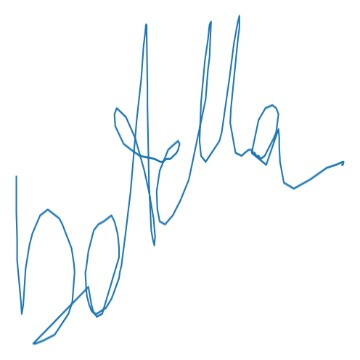

Has Parkinson Label: 0
Data Group Label: [1 0 0]


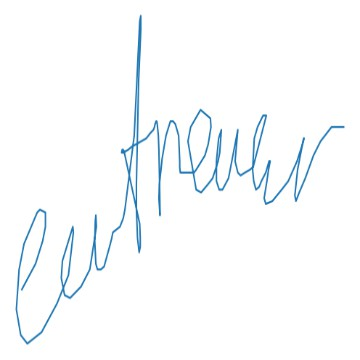

Has Parkinson Label: 0
Data Group Label: [1 0 0]


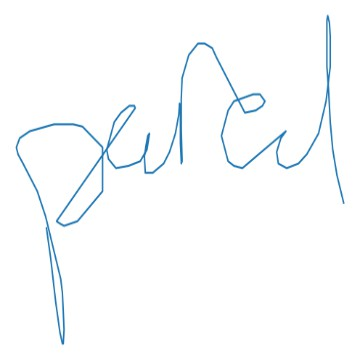

Has Parkinson Label: 0
Data Group Label: [1 0 0]


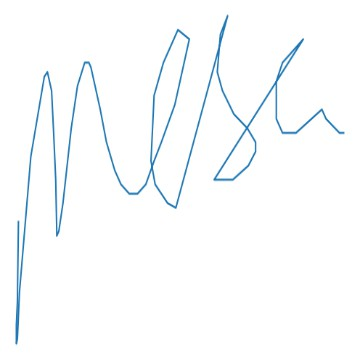

Has Parkinson Label: 0
Data Group Label: [1 0 0]


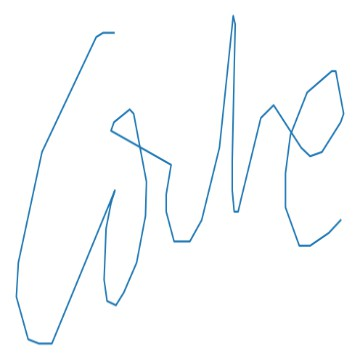

Has Parkinson Label: 0
Data Group Label: [1 0 0]


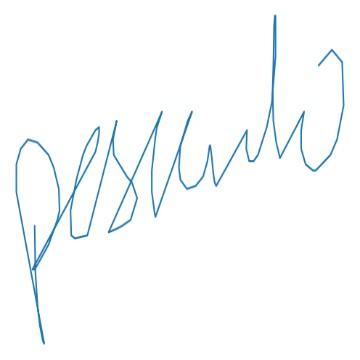

Has Parkinson Label: 0
Data Group Label: [1 0 0]


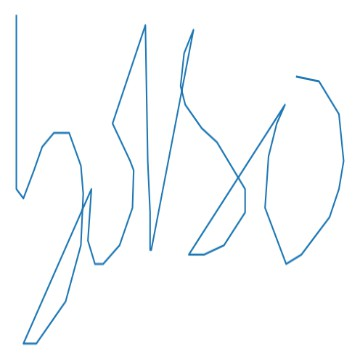

Has Parkinson Label: 0
Data Group Label: [1 0 0]


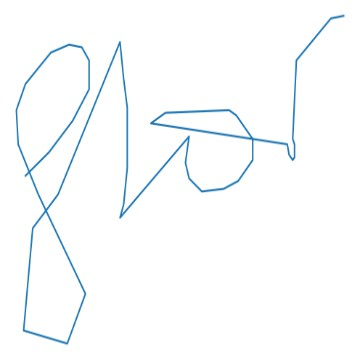

Has Parkinson Label: 0
Data Group Label: [1 0 0]


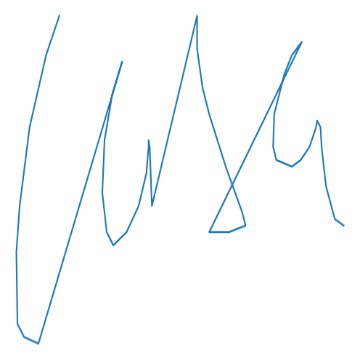

Has Parkinson Label: 0
Data Group Label: [1 0 0]


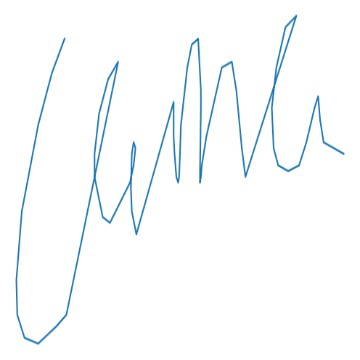

In [ ]:
import tensorflow as tf
import os
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
from sklearn.preprocessing import LabelBinarizer

tfrecord_filename = '/content/drive/MyDrive/pd_labels/hc.tfrecord'
# Read and parse the TFRecord file
raw_dataset = tf.data.TFRecordDataset(tfrecord_filename)
for raw_record in raw_dataset.take(10):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    # Decode the image from bytes
    image_bytes = example.features.feature['image'].bytes_list.value[0]
    image_np = np.frombuffer(image_bytes, dtype=np.uint8)
    image = cv2.imdecode(image_np, flags=cv2.IMREAD_COLOR)
    label_one_hot = np.array(example.features.feature['label'].int64_list.value)[0]
    tri_label_one_hot = np.array(example.features.feature['tri_label'].int64_list.value)
    print("Has Parkinson Label:", label_one_hot)
    print("Data Group Label:", tri_label_one_hot)
    cv2_imshow(image)

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Parche para usar cv2_imshow en Google

hc_tfrecord_filename = '/content/drive/MyDrive/pd_labels/hc.tfrecord'
left_tfrecord_filename = '/content/drive/MyDrive/pd_labels/left.tfrecord'
right_tfrecord_filename = '/content/drive/MyDrive/pd_labels/right.tfrecord'

def apply_data_augmentation(image):
    # Randomly flip horizontally
    if np.random.rand() > 0.5:
        image = np.fliplr(image)

    # Randomly flip vertically
    if np.random.rand() > 0.5:
        image = np.flipud(image)

    # Random brightness adjustment
    brightness_factor = 0.5 + np.random.rand()  # Adjust the range as needed
    image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    return image

def build_lists(tfrecord_filename, target_size=(224, 224), is_right= False):
    images = []
    labels = []

    # Lee los datos crudos del archivo TFRecord
    raw_dataset = tf.data.TFRecordDataset(tfrecord_filename)
    for raw_record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())

        # Recupera los datos de la imagen del ejemplo
        image_bytes = example.features.feature['image'].bytes_list.value[0]
        image_np = np.frombuffer(image_bytes, dtype=np.uint8)
        image = cv2.imdecode(image_np, flags=cv2.IMREAD_COLOR)

        # Resize the image to the target size
        image_resized = cv2.resize(image, target_size)

        # Apply ZCA whitening
        # Flatten the image
        flattened_image = image_resized.reshape((-1, 3))  # Reshape to (H*W, C)

        # Compute covariance matrix
        cov_matrix = np.cov(flattened_image, rowvar=False)

        # Compute ZCA whitening matrix
        epsilon = 1e-5  # small constant to avoid division by zero
        d, E = np.linalg.eigh(cov_matrix + epsilon * np.identity(cov_matrix.shape[0]))
        D = np.diag(1.0 / np.sqrt(d))
        whitening_matrix = np.dot(np.dot(E, D), E.T)

        # Apply ZCA whitening to flattened image
        flattened_image = np.dot(flattened_image, whitening_matrix.T)

        # Reshape flattened image back to original shape
        image_whitened = flattened_image.reshape((*target_size, 3))

        # Apply additional data augmentation
        augmented_images = [image_whitened]  # Original image

        if not is_right:
          for i in range(1):  # Rotate image 90 degrees
              augmented_images.append(np.rot90(image_whitened, k=i + 1))

        # Recupera los datos de la etiqueta (codificada en one-hot)
        label_one_hot = np.array(example.features.feature['label'].int64_list.value)

        # Agrega los datos de las imágenes y la etiqueta a sus respectivas listas
        images.extend(augmented_images)
        labels.extend([label_one_hot] * len(augmented_images))

    return [images, labels]

# Set the target size for resizing
# target_size = (299, 299)  # Adjust as needed
target_size = (128, 128)  # Adjust as needed
# target_size = (224, 224)  # Adjust as needed


# Convierte las listas de datos de imagen y etiqueta a matrices NumPy para el conjunto de entrenamiento
hc_images, hc_labels = build_lists(hc_tfrecord_filename, target_size)
print(len(hc_images))

# Convierte las listas de datos de imagen y etiqueta a matrices NumPy para el conjunto de prueba
left_images, left_labels = build_lists(left_tfrecord_filename, target_size)
print(len(left_images))

right_images, right_labels = build_lists(right_tfrecord_filename, target_size, True)
print(len(right_images))

2320
1200
920


In [ ]:
from sklearn.model_selection import train_test_split

# Concatenate images and labels for each class
all_images = hc_images + left_images + right_images
all_labels = hc_labels + left_labels + right_labels

# Convert lists to NumPy arrays
x_all = np.array(all_images)
y_all = np.array(all_labels)

# Split the data into training and testing sets (70% train, 30% test)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.3, random_state=42)

# Print the shapes of the resulting arrays
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of x_train: (3108, 128, 128, 3)
Shape of y_train: (3108, 1)
Shape of x_test: (1332, 128, 128, 3)
Shape of y_test: (1332, 1)


# Entrenamientos y Pruebas



## Funciones

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  # Plot training history
  plt.figure(figsize=(12, 6))

  # Plot training & validation accuracy values
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Test'], loc='upper left')

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Test'], loc='upper left')

  # Show the plots
  plt.show()

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

def con_matrix(custom_model, x_test, y_test, threshold=0.5):
    class_labels = ['No Parkinson', 'Parkinson']

    # Predict the probabilities on the test set
    y_pred_probabilities = custom_model.predict(x_test)

    # Convert probabilities to binary predictions using a threshold
    y_pred_classes = (y_pred_probabilities > threshold).astype(int)

    # Ensure that y_test is in the correct format (binary or multilabel)
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_true_classes = np.argmax(y_test, axis=1)  # Multilabel format
    else:
        y_true_classes = y_test.flatten()  # Binary format

    # Ensure that y_pred_classes is in the correct format (flatten for multilabel)
    if len(y_pred_classes.shape) > 1 and y_pred_classes.shape[1] > 1:
        y_pred_classes = np.argmax(y_pred_classes, axis=1)  # Flatten predictions for multilabel format

    # Generate the confusion matrix
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        conf_matrix = multilabel_confusion_matrix(y_true_classes, y_pred_classes)
    else:
        conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


## VGG16

### Models



#### Rejected

###### Picking Layers - 32 bsize - 100 epochs - Primer Experimento - 61.79%

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained VGG16 model without top (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Extract features from certain layers
block3_conv3 = base_model.get_layer('block3_conv3').output
block4_conv3 = base_model.get_layer('block4_conv3').output
block5_conv3 = base_model.get_layer('block5_conv3').output

# Apply normalization
block3_conv3 = BatchNormalization()(block3_conv3)
block4_conv3 = BatchNormalization()(block4_conv3)
block5_conv3 = BatchNormalization()(block5_conv3)

# Build your own model on top
x = Flatten()(block5_conv3)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

# Compile the model and specify the optimizer, loss, and metrics
optimizer = Adam(learning_rate=0.0001)  # Adjust the learning rate
custom_model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
98/98 [==============================] - 25s 168ms/step - loss: 0.8143 - accuracy: 0.5595 - val_loss: 0.7337 - val_accuracy: 0.5616
Epoch 2/100
98/98 [==============================] - 13s 127ms/step - loss: 0.7080 - accuracy: 0.5988 - val_loss: 0.6973 - val_accuracy: 0.5871
Epoch 3/100
98/98 [==============================] - 12s 127ms/step - loss: 0.6548 - accuracy: 0.6236 - val_loss: 0.7059 - val_accuracy: 0.5931
Epoch 4/100
98/98 [==============================] - 12s 126ms/step - loss: 0.6281 - accuracy: 0.6477 - val_loss: 0.7243 - val_accuracy: 0.6044
Epoch 5/100
98/98 [==============================] - 12s 127ms/step - loss: 0.6236 - accuracy: 0.6525 - val_loss: 0.7096 - val_accuracy: 0.5961
Epoch 6/100
98/98 [==============================] - 13s 128ms/step - loss: 0.6116 - accuracy: 0.6667 - val_loss: 0.7223 - val_accuracy: 0.6051
Epoch 7/100
98/98 [==============================] - 12s 126ms/step - loss: 0.6003 - accuracy: 0.6715 - val_loss: 0.7305 - val_accuracy:

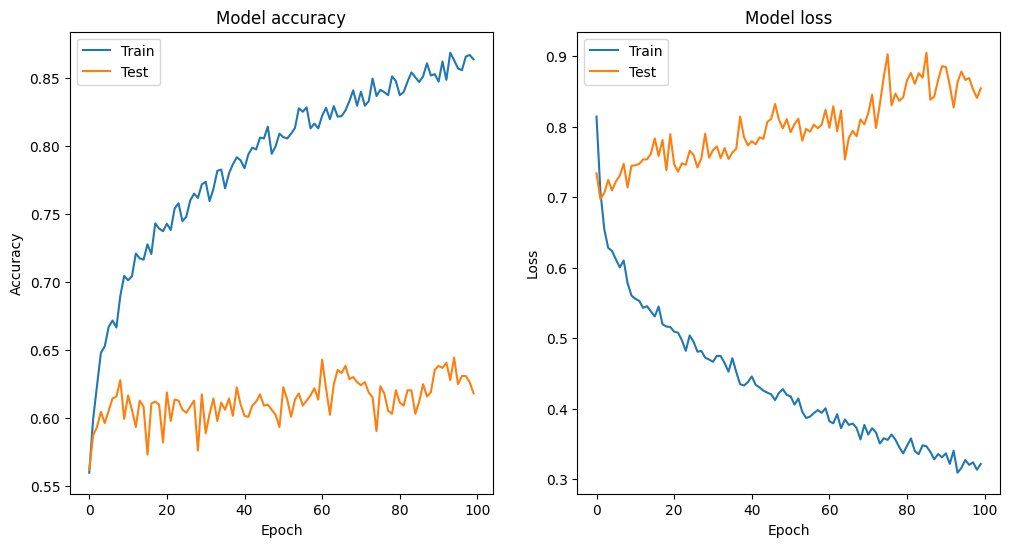

42/42 [==============================] - 2s 42ms/step


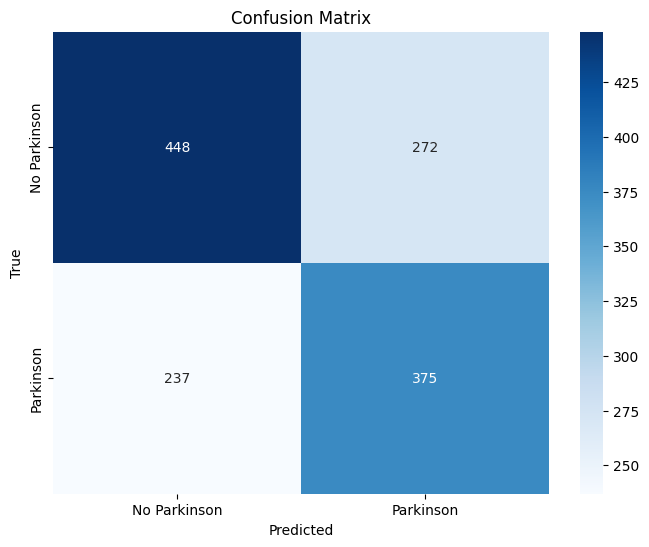

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

###### Picking Layers - 64 bsize - 100 epochs - Segundo Experimento - 63.89%

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained VGG16 model with top (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Freeze the first three convolutional layers
for layer in base_model.layers[:3]:
    layer.trainable = False

# Use the existing fully connected layers
x = base_model.get_layer('flatten').output
output = Dense(1, activation='sigmoid')(x)

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

custom_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()


553467096/553467096 [==============================] - 25s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
49/49 [==============================] - 98s 1s/step - loss: 0.7091 - accuracy: 0.5080 - val_loss: 0.6805 - val_accuracy: 0.5586
Epoch 2/100
49/49 [==============================] - 37s 746ms/step - loss: 0.6884 - accuracy: 0.5528 - val_loss: 0.6828 - val_accuracy: 0.5736
Epoch 3/100
49/49 [==============================] - 38s 759ms/step - loss: 0.6804 - accuracy: 0.5730 - val_loss: 0.6883 - val_accuracy: 0.5473
Epoch 4/100
49/49 [==============================] - 36s 731ms/step - loss: 0.6865 - accuracy: 0.5644 - val_loss: 0.6813 - val_accuracy: 0.5826
Epoch 5/100
49/49 [==============================] - 36s 729ms/step - loss: 0.6828 - accuracy: 0.5692 - val_loss: 0.6721 - val_accuracy: 0.5743
Epoch 6/100
49/49 [==============================] - 37s 750ms/step - loss: 0.6789 - accuracy: 0.5714 - val_loss: 0.6843 - val_accuracy: 0.5593
Epoch 7/100
49/49 [==============================] - 37s 743ms/step - loss: 0.6781 - accuracy: 0.5795 - val_loss: 0.6758 - val_accuracy: 0.

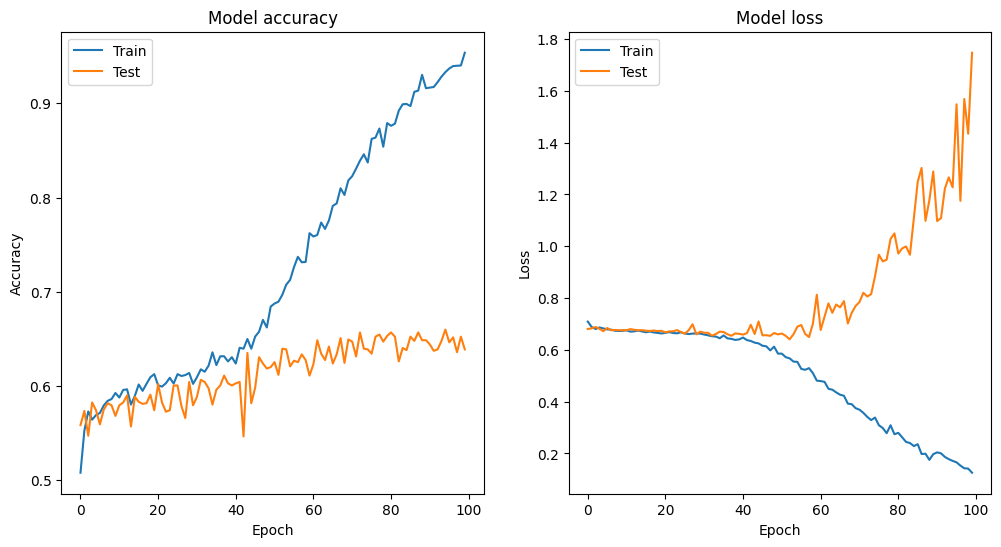

42/42 [==============================] - 5s 115ms/step


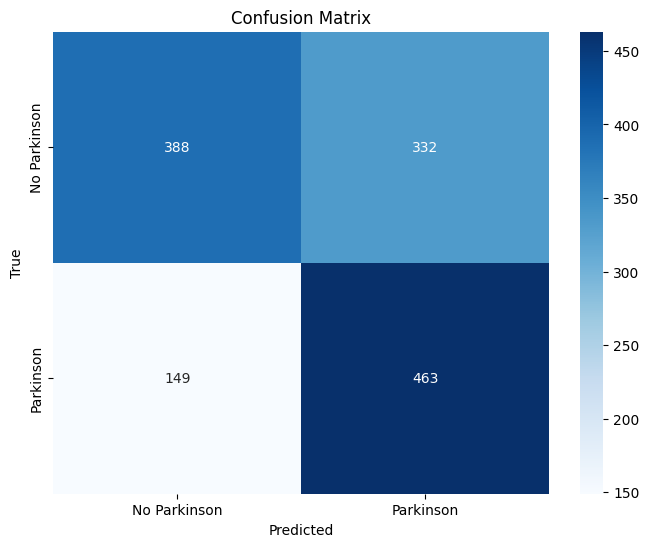

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

###### Picking Layers - 32 Batches - 100 epochs - Tercer Experimento - 66.52%

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained VGG16 model with top (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the first 11 convolutional layers
for layer in base_model.layers[:11]:
    layer.trainable = False

block4_conv1 = base_model.get_layer('block4_conv1').output
block4_conv1 = BatchNormalization()(block4_conv1)
block4_conv1 =  Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block4_conv1)
block4_conv1 =  Dropout(0.1)(block4_conv1)  # Adding dropout for additional regularization

block4_conv2 = base_model.get_layer('block4_conv2').output
block4_conv2 = BatchNormalization()(block4_conv2)
block4_conv2 =  Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block4_conv2)
block4_conv2 =  Dropout(0.2)(block4_conv2)  # Adding dropout for additional regularization

block4_conv3 = base_model.get_layer('block4_conv3').output
block4_conv3 = BatchNormalization()(block4_conv3)
block4_conv3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block4_conv3)
block4_conv3 = Dropout(0.3)(block4_conv3)  # Adding dropout for additional regularization

block5_conv1 = base_model.get_layer('block5_conv1').output
block5_conv1 = BatchNormalization()(block5_conv1)
block5_conv1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block5_conv1)
block5_conv1 = Dropout(0.4)(block5_conv1)  # Adding dropout for additional regularization

block5_conv2 = base_model.get_layer('block5_conv2').output
block5_conv2 = BatchNormalization()(block5_conv2)
block5_conv2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block5_conv2)
block5_conv2 = Dropout(0.45)(block5_conv2)  # Adding dropout for additional regularization

block5_conv3 = base_model.get_layer('block5_conv3').output
block5_conv3 = BatchNormalization()(block5_conv3)
block5_conv3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block5_conv3)
block5_conv3 = Dropout(0.5)(block5_conv3)  # Adding dropout for additional regularization

# Create custom fully connected layers
x = Flatten()(block5_conv3)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Adding dropout for additional regularization
output = Dense(1, activation='sigmoid')(x)

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

# Remove non-trainable layers from the end
while custom_model.layers and not custom_model.layers[-1].trainable:
    custom_model.layers.pop()

custom_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
98/98 [==============================] - 15s 116ms/step - loss: 1.0568 - accuracy: 0.5306 - val_loss: 0.7892 - val_accuracy: 0.5548
Epoch 2/100
98/98 [==============================] - 11s 108ms/step - loss: 0.9742 - accuracy: 0.5579 - val_loss: 0.8276 - val_accuracy: 0.5571
Epoch 3/100
98/98 [==============================] - 11s 110ms/step - loss: 0.9855 - accuracy: 0.5714 - val_loss: 0.7953 - val_accuracy: 0.5541
Epoch 4/100
98/98 [==============================] - 11s 109ms/step - loss: 0.9496 - accuracy: 0.5653 - val_loss: 0.8643 - val_accuracy: 0.5991
Epoch 5/100
98/98 [==============================] - 10s 107ms/step - loss: 0.9435 - accuracy: 0.5856 - val_loss: 0.8240 - val_accuracy: 0.5495
Epoch 6/100
98/98 [==============================] - 10s 107ms/step - loss: 0.8990 - accuracy: 0.5804 - val_loss: 1.0113 - val_accuracy: 0.5908
Epoch 7/100
98/98 [==============================] - 10s 106ms/step - loss: 0.9068 - accuracy: 0.5769 - val_loss: 0.9060 - val_accuracy:

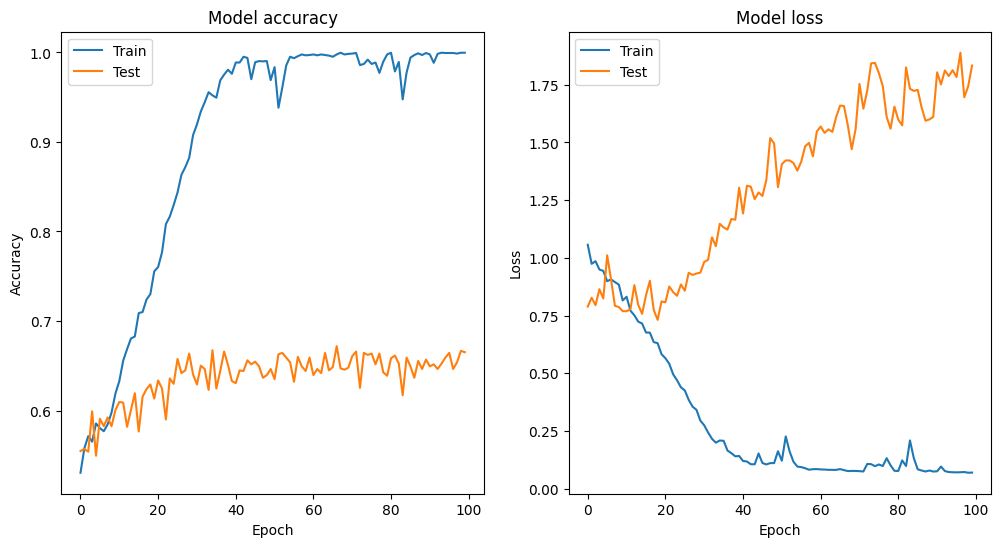

42/42 [==============================] - 2s 41ms/step


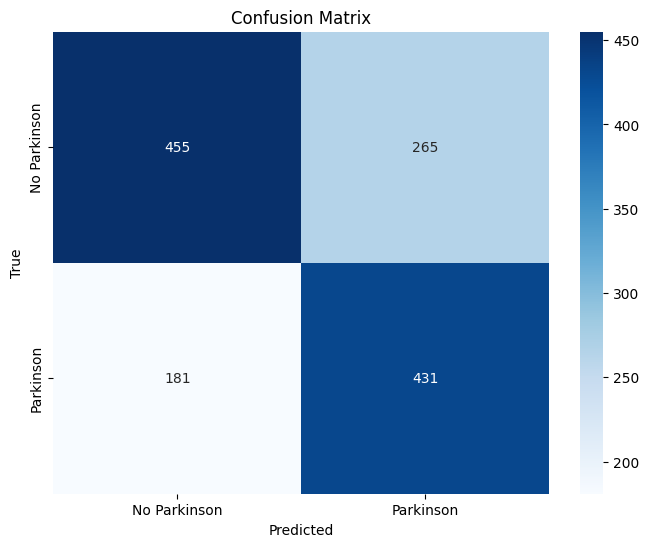

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

## VGG19

### Models

#### Rejected

###### Picking Layers - 32 bsize - 100 epochs - Primer Expermiento - 64.04%

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained VGG19 model without top (fully connected layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Extract features from certain layers
block3_conv3 = base_model.get_layer('block3_conv3').output
block4_conv3 = base_model.get_layer('block4_conv3').output
block5_conv3 = base_model.get_layer('block5_conv3').output

# Apply normalization
block3_conv3 = BatchNormalization()(block3_conv3)
block4_conv3 = BatchNormalization()(block4_conv3)
block5_conv3 = BatchNormalization()(block5_conv3)

# Build your own model on top
x = Flatten()(block5_conv3)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

# Compile the model and specify the optimizer, loss, and metrics
optimizer = Adam(learning_rate=0.0001)  # Adjust the learning rate
custom_model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()


80134624/80134624 [==============================] - 3s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                            

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
98/98 [==============================] - 17s 143ms/step - loss: 0.8361 - accuracy: 0.5515 - val_loss: 1.2546 - val_accuracy: 0.4850
Epoch 2/100
98/98 [==============================] - 13s 135ms/step - loss: 0.6833 - accuracy: 0.6133 - val_loss: 1.0215 - val_accuracy: 0.5120
Epoch 3/100
98/98 [==============================] - 13s 134ms/step - loss: 0.6475 - accuracy: 0.6329 - val_loss: 0.7550 - val_accuracy: 0.5548
Epoch 4/100
98/98 [==============================] - 13s 135ms/step - loss: 0.6122 - accuracy: 0.6577 - val_loss: 0.7246 - val_accuracy: 0.5833
Epoch 5/100
98/98 [==============================] - 13s 133ms/step - loss: 0.5883 - accuracy: 0.6715 - val_loss: 0.6786 - val_accuracy: 0.6141
Epoch 6/100
98/98 [==============================] - 13s 135ms/step - loss: 0.5962 - accuracy: 0.6734 - val_loss: 0.6912 - val_accuracy: 0.5998
Epoch 7/100
98/98 [==============================] - 13s 134ms/step - loss: 0.5635 - accuracy: 0.6988 - val_loss: 0.6710 - val_accuracy:

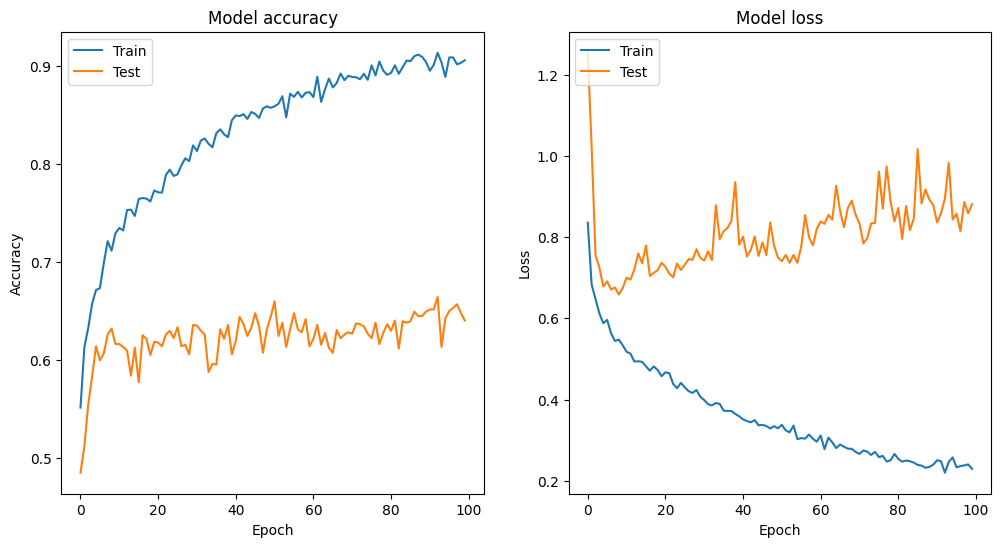

42/42 [==============================] - 2s 47ms/step


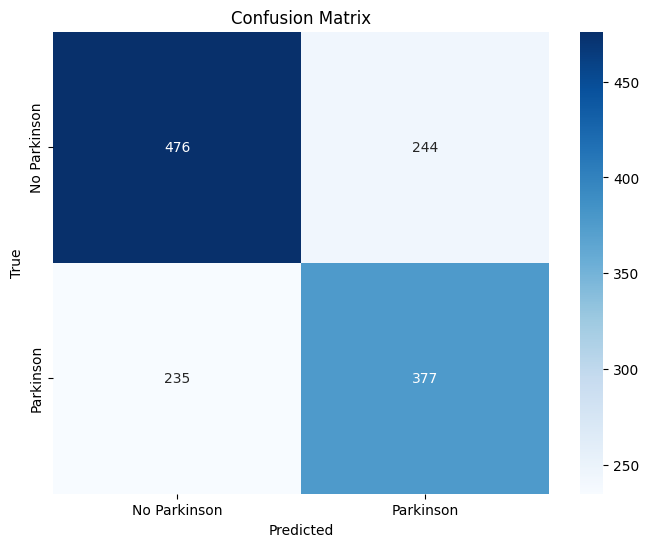

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

###### Picking Layers - 64 bsize - 100 epochs - Segundo Experimento - 60.51%

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained VGG19 model with top (fully connected layers)
base_model = VGG19(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Freeze the first three convolutional layers
for layer in base_model.layers[:3]:
    layer.trainable = False

# Use the existing fully connected layers
x = base_model.get_layer('flatten').output
output = Dense(1, activation='sigmoid')(x)

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

custom_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()


574710816/574710816 [==============================] - 20s 0us/step
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                        

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
49/49 [==============================] - 110s 2s/step - loss: 0.7035 - accuracy: 0.5074 - val_loss: 0.6896 - val_accuracy: 0.5405
Epoch 2/100
49/49 [==============================] - 45s 899ms/step - loss: 0.6944 - accuracy: 0.5055 - val_loss: 0.6907 - val_accuracy: 0.5443
Epoch 3/100
49/49 [==============================] - 44s 889ms/step - loss: 0.6928 - accuracy: 0.5138 - val_loss: 0.6896 - val_accuracy: 0.5405
Epoch 4/100
49/49 [==============================] - 44s 893ms/step - loss: 0.6925 - accuracy: 0.5164 - val_loss: 0.6885 - val_accuracy: 0.5405
Epoch 5/100
49/49 [==============================] - 44s 891ms/step - loss: 0.6904 - accuracy: 0.5309 - val_loss: 0.6870 - val_accuracy: 0.5405
Epoch 6/100
49/49 [==============================] - 44s 891ms/step - loss: 0.6959 - accuracy: 0.5068 - val_loss: 0.6946 - val_accuracy: 0.4752
Epoch 7/100
49/49 [==============================] - 45s 901ms/step - loss: 0.6855 - accuracy: 0.5534 - val_loss: 0.6729 - val_accuracy: 0

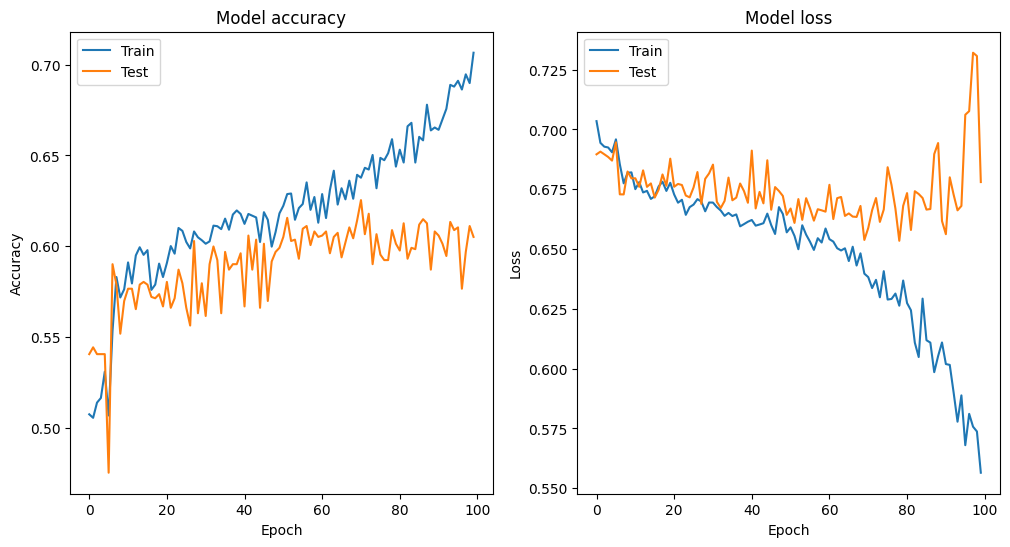

42/42 [==============================] - 6s 146ms/step


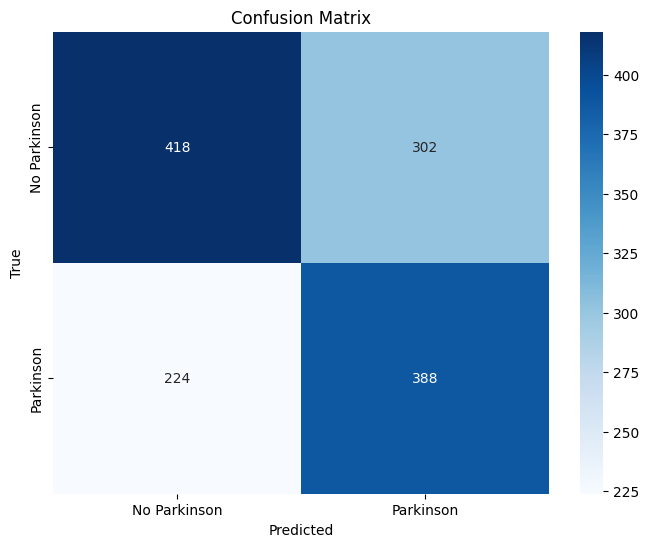

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

###### Picking Layers - 32 Batches - 100 epochs - Tercer Experimento - 67.79%

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained VGG19 model with top (fully connected layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the first 11 convolutional layers
for layer in base_model.layers[:11]:
    layer.trainable = False


# Capas entrenable

# block4_conv1 (Conv2D)       (None, 16, 16, 512)       1180160

#  block4_conv2 (Conv2D)       (None, 16, 16, 512)       2359808

#  block4_conv3 (Conv2D)       (None, 16, 16, 512)       2359808

#  block4_pool (MaxPooling2D)  (None, 8, 8, 512)         0

#  block5_conv1 (Conv2D)       (None, 8, 8, 512)         2359808

#  block5_conv2 (Conv2D)       (None, 8, 8, 512)         2359808

#  block5_conv3 (Conv2D)       (None, 8, 8, 512)         2359808

block4_conv1 = base_model.get_layer('block4_conv1').output
block4_conv1 = BatchNormalization()(block4_conv1)
block4_conv1 =  Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block4_conv1)
block4_conv1 =  Dropout(0.1)(block4_conv1)  # Adding dropout for additional regularization

block4_conv2 = base_model.get_layer('block4_conv2').output
block4_conv2 = BatchNormalization()(block4_conv2)
block4_conv2 =  Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block4_conv2)
block4_conv2 =  Dropout(0.2)(block4_conv2)  # Adding dropout for additional regularization

block4_conv3 = base_model.get_layer('block4_conv3').output
block4_conv3 = BatchNormalization()(block4_conv3)
block4_conv3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block4_conv3)
block4_conv3 = Dropout(0.3)(block4_conv3)  # Adding dropout for additional regularization

block5_conv1 = base_model.get_layer('block5_conv1').output
block5_conv1 = BatchNormalization()(block5_conv1)
block5_conv1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block5_conv1)
block5_conv1 = Dropout(0.4)(block5_conv1)  # Adding dropout for additional regularization

block5_conv2 = base_model.get_layer('block5_conv2').output
block5_conv2 = BatchNormalization()(block5_conv2)
block5_conv2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block5_conv2)
block5_conv2 = Dropout(0.45)(block5_conv2)  # Adding dropout for additional regularization

block5_conv3 = base_model.get_layer('block5_conv3').output
block5_conv3 = BatchNormalization()(block5_conv3)
block5_conv3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block5_conv3)
block5_conv3 = Dropout(0.5)(block5_conv3)  # Adding dropout for additional regularization

# Create custom fully connected layers
x = Flatten()(block5_conv3)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Adding dropout for additional regularization
output = Dense(1, activation='sigmoid')(x)

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

# Remove non-trainable layers from the end
while custom_model.layers and not custom_model.layers[-1].trainable:
    custom_model.layers.pop()

custom_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
98/98 [==============================] - 17s 134ms/step - loss: 1.0583 - accuracy: 0.5270 - val_loss: 0.8701 - val_accuracy: 0.5503
Epoch 2/100
98/98 [==============================] - 12s 124ms/step - loss: 0.9949 - accuracy: 0.5505 - val_loss: 0.7865 - val_accuracy: 0.5631
Epoch 3/100
98/98 [==============================] - 12s 125ms/step - loss: 0.9840 - accuracy: 0.5586 - val_loss: 0.9022 - val_accuracy: 0.5338
Epoch 4/100
98/98 [==============================] - 12s 126ms/step - loss: 0.9218 - accuracy: 0.5775 - val_loss: 0.8051 - val_accuracy: 0.6074
Epoch 5/100
98/98 [==============================] - 12s 127ms/step - loss: 0.8877 - accuracy: 0.6055 - val_loss: 0.7845 - val_accuracy: 0.6104
Epoch 6/100
98/98 [==============================] - 12s 127ms/step - loss: 0.8653 - accuracy: 0.6129 - val_loss: 0.7835 - val_accuracy: 0.5991
Epoch 7/100
98/98 [==============================] - 12s 128ms/step - loss: 0.8781 - accuracy: 0.6004 - val_loss: 0.9208 - val_accuracy:

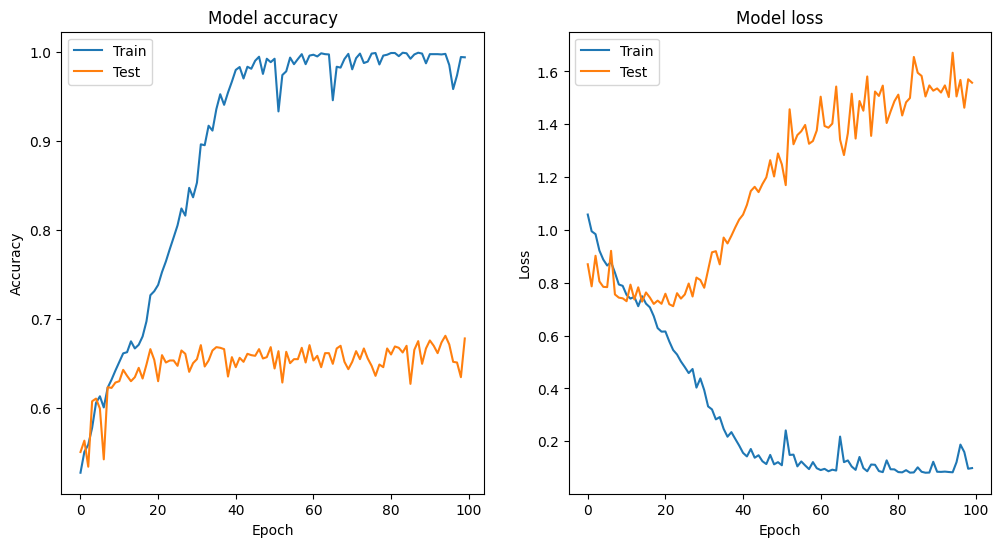

42/42 [==============================] - 2s 49ms/step


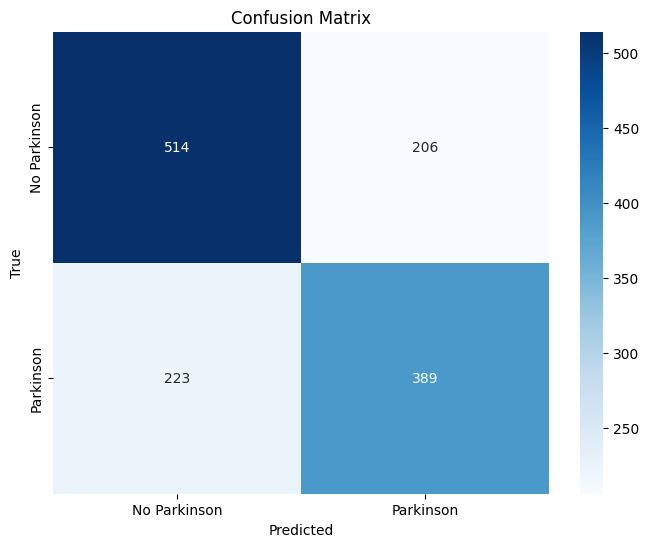

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

## ResNet

### Modelos

#### Rejected

###### Picking Layers - 32 bsize - 100 epochs - Primer Expermiento - 53.68%

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained ResNet50V2 model without top (fully connected layers)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Extract features from certain layers
block3_conv3 = base_model.get_layer('conv3_block4_out').output
block4_conv3 = base_model.get_layer('conv4_block6_out').output
block5_conv3 = base_model.get_layer('conv5_block3_out').output

# Apply normalization
block3_conv3 = BatchNormalization()(block3_conv3)
block4_conv3 = BatchNormalization()(block4_conv3)
block5_conv3 = BatchNormalization()(block5_conv3)

# Build your own model on top
x = Flatten()(block5_conv3)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

# Compile the model and specify the optimizer, loss, and metrics
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate
custom_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()



Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_19[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                           

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
98/98 [==============================] - 18s 138ms/step - loss: 0.7099 - accuracy: 0.5569 - val_loss: 6.6086 - val_accuracy: 0.5015
Epoch 2/100
98/98 [==============================] - 12s 124ms/step - loss: 0.6845 - accuracy: 0.5692 - val_loss: 0.7224 - val_accuracy: 0.5420
Epoch 3/100
98/98 [==============================] - 12s 123ms/step - loss: 0.6785 - accuracy: 0.5766 - val_loss: 0.7717 - val_accuracy: 0.5158
Epoch 4/100
98/98 [==============================] - 12s 124ms/step - loss: 0.6794 - accuracy: 0.5894 - val_loss: 0.9715 - val_accuracy: 0.5120
Epoch 5/100
98/98 [==============================] - 12s 123ms/step - loss: 0.6820 - accuracy: 0.5746 - val_loss: 0.7504 - val_accuracy: 0.5240
Epoch 6/100
98/98 [==============================] - 12s 121ms/step - loss: 0.6737 - accuracy: 0.5894 - val_loss: 0.7160 - val_accuracy: 0.5390
Epoch 7/100
98/98 [==============================] - 12s 125ms/step - loss: 0.6718 - accuracy: 0.6039 - val_loss: 0.9344 - val_accuracy:

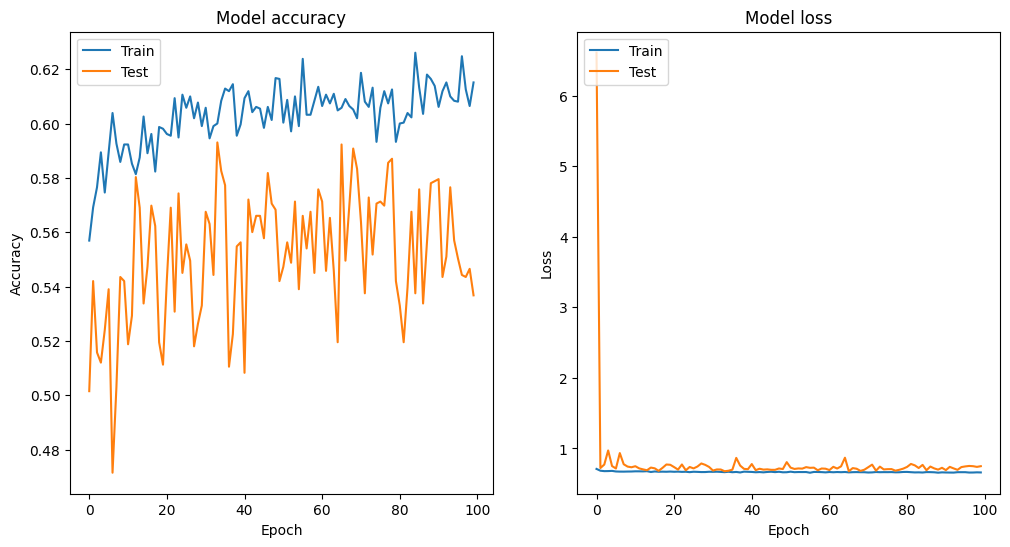

42/42 [==============================] - 2s 33ms/step


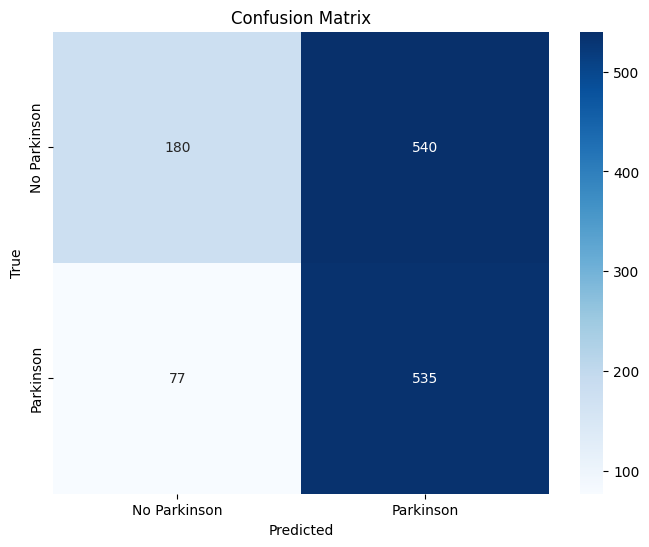

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

###### Picking Layers - 64 bsize - 100 epochs - Segundo Experimento - 67.72%

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained ResNet50V2 model with top (fully connected layers)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the first three convolutional layers
for layer in base_model.layers[:3]:
    layer.trainable = False

# Use global average pooling instead of flatten
x = GlobalAveragePooling2D()(base_model.output)

# Add custom fully connected layers
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
custom_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()



Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_48 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_48[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                           

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
49/49 [==============================] - 80s 949ms/step - loss: 0.6751 - accuracy: 0.6001 - val_loss: 0.7612 - val_accuracy: 0.5248
Epoch 2/100
49/49 [==============================] - 35s 713ms/step - loss: 0.6109 - accuracy: 0.6519 - val_loss: 0.7782 - val_accuracy: 0.5330
Epoch 3/100
49/49 [==============================] - 35s 707ms/step - loss: 0.5704 - accuracy: 0.6856 - val_loss: 0.7026 - val_accuracy: 0.6104
Epoch 4/100
49/49 [==============================] - 36s 723ms/step - loss: 0.5327 - accuracy: 0.7130 - val_loss: 0.6744 - val_accuracy: 0.6441
Epoch 5/100
49/49 [==============================] - 36s 726ms/step - loss: 0.5049 - accuracy: 0.7278 - val_loss: 0.8519 - val_accuracy: 0.6321
Epoch 6/100
49/49 [==============================] - 36s 735ms/step - loss: 0.4848 - accuracy: 0.7477 - val_loss: 0.7299 - val_accuracy: 0.6134
Epoch 7/100
49/49 [==============================] - 34s 692ms/step - loss: 0.4671 - accuracy: 0.7661 - val_loss: 0.6408 - val_accuracy:

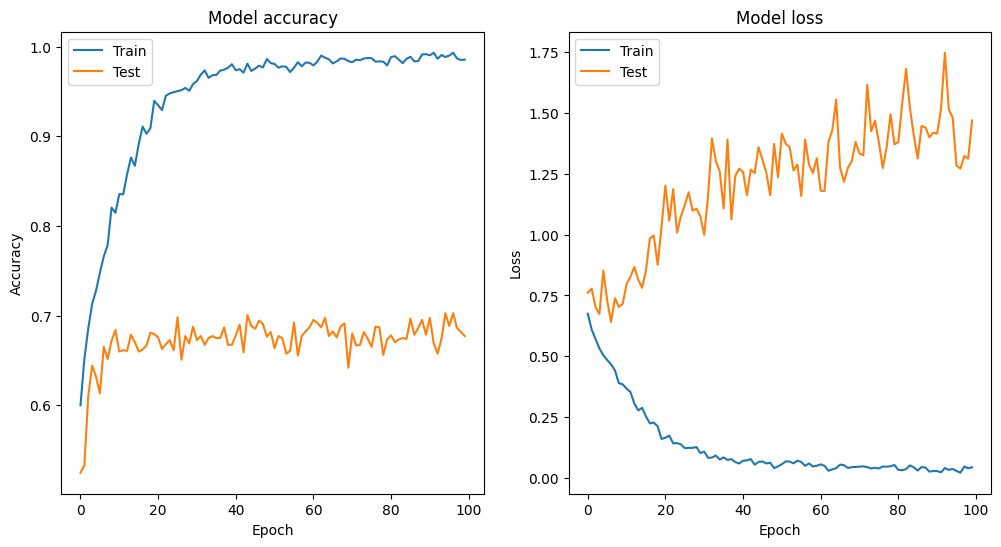

42/42 [==============================] - 4s 86ms/step


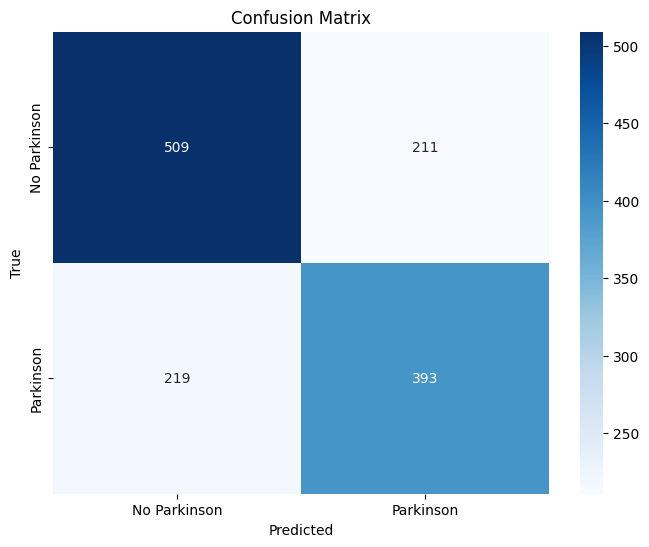

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

###### Picking Layers - 32 Batches - 100 epochs - Tercer Experimento - 59.46%

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained ResNet50V2 model with top (fully connected layers)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the first few layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Extract features from intermediate layers
block3_out = base_model.get_layer('conv3_block4_out').output
block4_out = base_model.get_layer('conv4_block6_out').output
block5_out = base_model.get_layer('conv5_block3_out').output

# BatchNormalization and Conv2D for additional regularization
block3_out = BatchNormalization()(block3_out)
block3_out = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block3_out)
block3_out = Dropout(0.1)(block3_out)

block4_out = BatchNormalization()(block4_out)
block4_out = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block4_out)
block4_out = Dropout(0.2)(block4_out)

block5_out = BatchNormalization()(block5_out)
block5_out = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block5_out)
block5_out = Dropout(0.3)(block5_out)

# Create custom fully connected layers
x = Flatten()(block5_out)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

# Remove non-trainable layers from the end
while custom_model.layers and not custom_model.layers[-1].trainable:
    custom_model.layers.pop()

custom_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_12[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                           

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
98/98 [==============================] - 16s 95ms/step - loss: 1.0527 - accuracy: 0.5180 - val_loss: 0.8382 - val_accuracy: 0.4745
Epoch 2/100
98/98 [==============================] - 7s 69ms/step - loss: 1.0188 - accuracy: 0.5199 - val_loss: 0.8882 - val_accuracy: 0.5450
Epoch 3/100
98/98 [==============================] - 7s 69ms/step - loss: 0.9827 - accuracy: 0.5273 - val_loss: 0.8132 - val_accuracy: 0.5578
Epoch 4/100
98/98 [==============================] - 7s 70ms/step - loss: 0.9885 - accuracy: 0.5103 - val_loss: 0.8012 - val_accuracy: 0.5691
Epoch 5/100
98/98 [==============================] - 7s 70ms/step - loss: 0.9684 - accuracy: 0.5370 - val_loss: 0.8261 - val_accuracy: 0.5616
Epoch 6/100
98/98 [==============================] - 7s 70ms/step - loss: 0.9749 - accuracy: 0.5302 - val_loss: 0.8239 - val_accuracy: 0.5263
Epoch 7/100
98/98 [==============================] - 7s 70ms/step - loss: 0.9411 - accuracy: 0.5389 - val_loss: 0.7896 - val_accuracy: 0.5691
Epoch

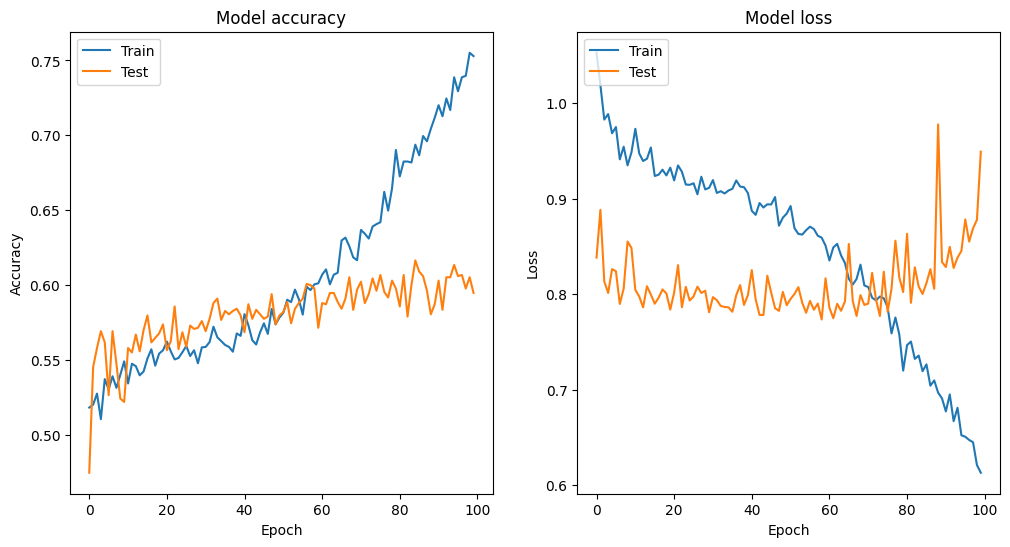

42/42 [==============================] - 2s 36ms/step


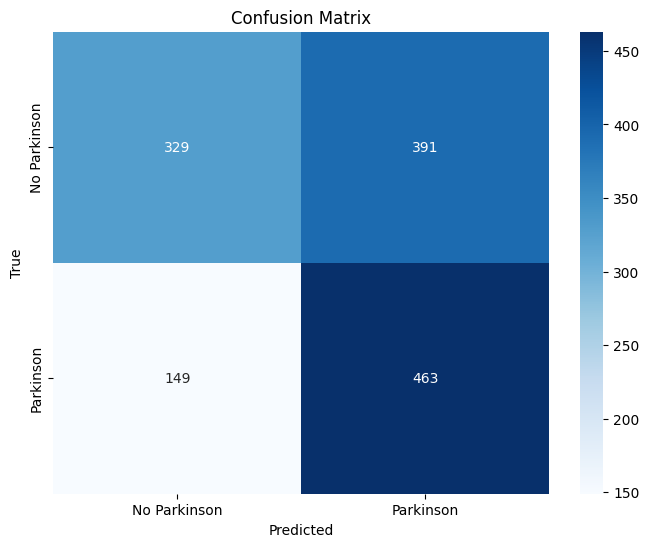

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

## MobileNet

### Modelos

#### Rejected

###### Picking Layers - 32 bsize - 100 epochs - Primer Expermiento - 55.26%

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained MobileNetV3Small model without top (fully connected layers)
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Get the index of the last layer
last_layer_index = -1  # Index -1 corresponds to the last layer

# Extract features from the last convolutional block
block_out = base_model.get_layer(index=last_layer_index).output

# Apply normalization
block_out = BatchNormalization()(block_out)

# Build your own model on top
x = GlobalAveragePooling2D()(block_out)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

# Compile the model and specify the optimizer, loss, and metrics
optimizer = Adam(learning_rate=0.0001)  # Adjust the learning rate
custom_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling_17 (Rescaling)    (None, 128, 128, 3)          0         ['input_31[0][0]']            
                                                                                                  
 Conv (Conv2D)               (None, 64, 64, 16)           432       ['rescaling_17[0][0]']        
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 64, 64, 16)           64        ['Conv[0][0]']                
 lization)                                                                                 

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
98/98 [==============================] - 21s 150ms/step - loss: 0.7869 - accuracy: 0.5479 - val_loss: 0.6895 - val_accuracy: 0.5353
Epoch 2/100
98/98 [==============================] - 12s 118ms/step - loss: 0.7286 - accuracy: 0.5763 - val_loss: 0.6895 - val_accuracy: 0.5263
Epoch 3/100
98/98 [==============================] - 11s 115ms/step - loss: 0.7101 - accuracy: 0.5782 - val_loss: 0.6980 - val_accuracy: 0.5255
Epoch 4/100
98/98 [==============================] - 11s 114ms/step - loss: 0.6842 - accuracy: 0.5940 - val_loss: 0.7275 - val_accuracy: 0.5218
Epoch 5/100
98/98 [==============================] - 12s 118ms/step - loss: 0.6915 - accuracy: 0.5933 - val_loss: 0.7958 - val_accuracy: 0.5330
Epoch 6/100
98/98 [==============================] - 11s 117ms/step - loss: 0.6760 - accuracy: 0.6014 - val_loss: 0.8421 - val_accuracy: 0.5323
Epoch 7/100
98/98 [==============================] - 12s 117ms/step - loss: 0.6756 - accuracy: 0.6081 - val_loss: 0.8541 - val_accuracy:

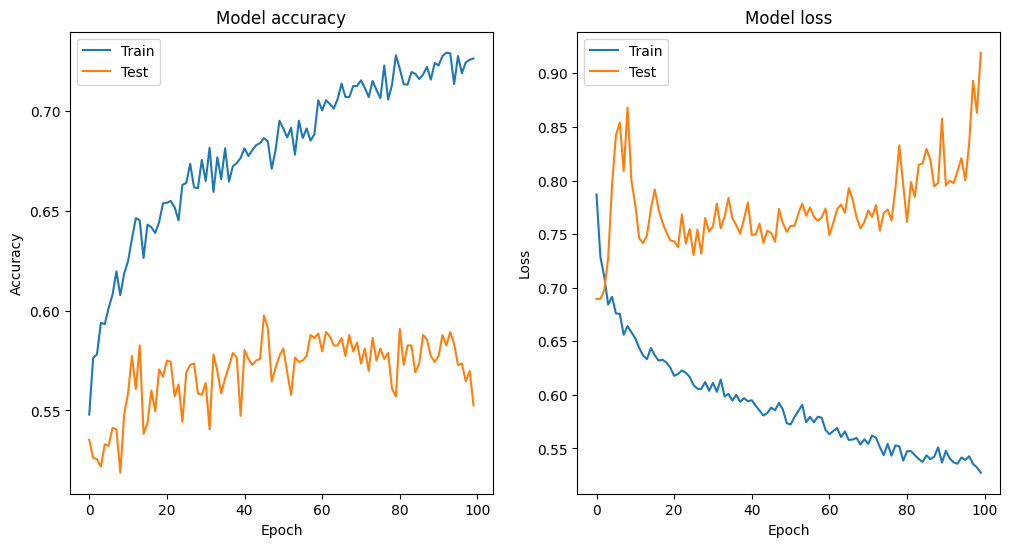

42/42 [==============================] - 2s 10ms/step


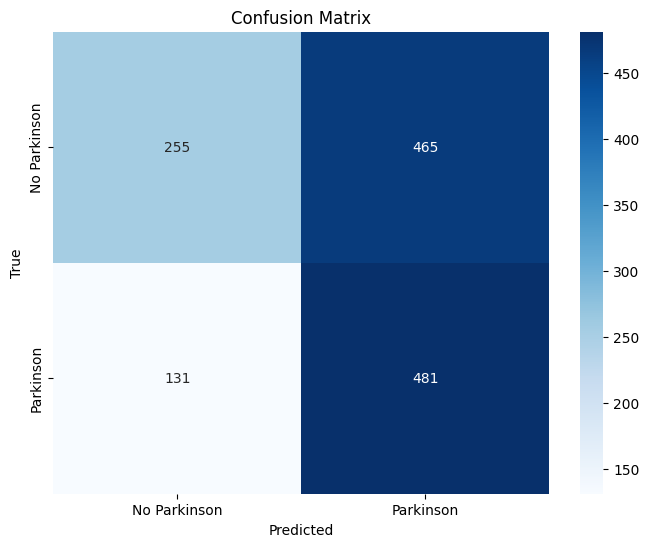

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

###### Picking Layers - 64 bsize - 100 epochs - Segundo Experimento - 57.43%

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Load pre-trained MobileNetV3 Small model with top (fully connected layers)
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add your custom fully connected layers
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

custom_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()



Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_28 (Rescaling)    (None, 224, 224, 3)          0         ['input_49[0][0]']            
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_28[0][0]']        
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                 

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
49/49 [==============================] - 39s 705ms/step - loss: 0.6983 - accuracy: 0.4887 - val_loss: 0.7014 - val_accuracy: 0.4820
Epoch 2/100
49/49 [==============================] - 32s 647ms/step - loss: 0.6980 - accuracy: 0.4801 - val_loss: 0.7004 - val_accuracy: 0.4880
Epoch 3/100
49/49 [==============================] - 31s 623ms/step - loss: 0.6969 - accuracy: 0.4875 - val_loss: 0.6985 - val_accuracy: 0.4970
Epoch 4/100
49/49 [==============================] - 32s 652ms/step - loss: 0.6954 - accuracy: 0.4984 - val_loss: 0.6972 - val_accuracy: 0.4962
Epoch 5/100
49/49 [==============================] - 32s 645ms/step - loss: 0.6940 - accuracy: 0.5071 - val_loss: 0.6963 - val_accuracy: 0.4985
Epoch 6/100
49/49 [==============================] - 31s 622ms/step - loss: 0.6930 - accuracy: 0.5090 - val_loss: 0.6955 - val_accuracy: 0.4977
Epoch 7/100
49/49 [==============================] - 31s 633ms/step - loss: 0.6915 - accuracy: 0.5106 - val_loss: 0.6932 - val_accuracy:

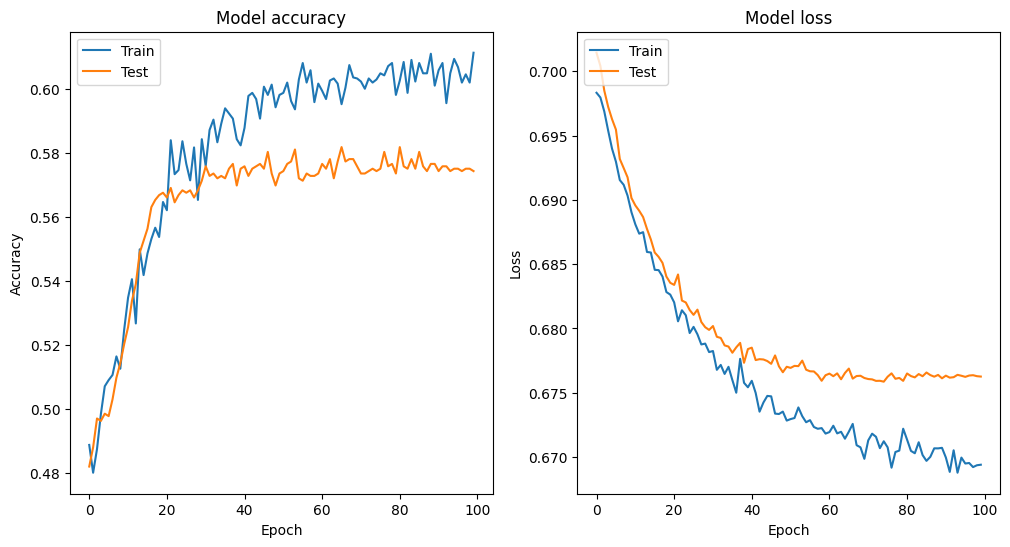

42/42 [==============================] - 2s 21ms/step


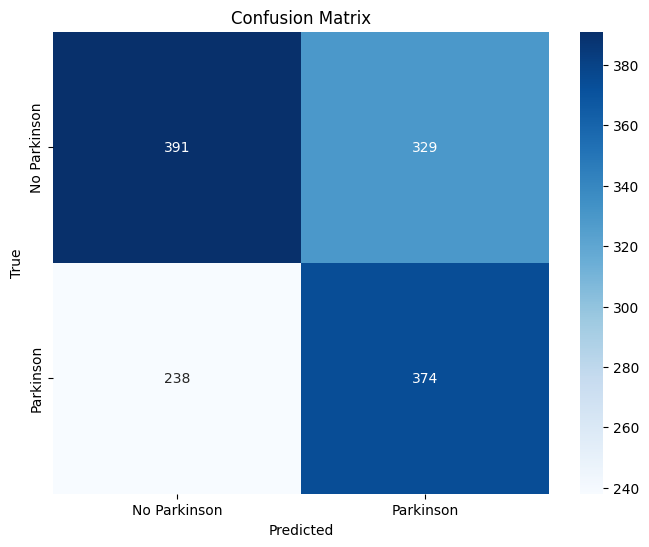

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

###### Picking Layers - 32 Batches - 100 epochs - Tercer Experimento - 59.53%

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained MobileNetV3Small model with top (fully connected layers)
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Adjust the number of trainable layers according to your preference
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Use existing layers from MobileNetV3Small
expand_layer_names = [
    'expanded_conv_6/project',
    'expanded_conv_10/project',
    'Conv_1',
    'Conv_1/BatchNorm'
]

block4_conv = [base_model.get_layer(name).output for name in expand_layer_names]

# You can customize the dropout rates and other parameters as needed
for i, block in enumerate(block4_conv):
    block = BatchNormalization()(block)
    block = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block)
    block = Dropout(0.1 * (i + 1))(block)

# Continue with the remaining layers similarly

# Create custom fully connected layers
x = Flatten()(block4_conv[-1])  # Use the last block's output
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

# Remove non-trainable layers from the end
while custom_model.layers and not custom_model.layers[-1].trainable:
    custom_model.layers.pop()

custom_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()



Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_42 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling_27 (Rescaling)    (None, 128, 128, 3)          0         ['input_42[0][0]']            
                                                                                                  
 Conv (Conv2D)               (None, 64, 64, 16)           432       ['rescaling_27[0][0]']        
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 64, 64, 16)           64        ['Conv[0][0]']                
 lization)                                                                                 

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
98/98 [==============================] - 8s 35ms/step - loss: 0.8882 - accuracy: 0.5187 - val_loss: 0.8002 - val_accuracy: 0.4962
Epoch 2/100
98/98 [==============================] - 2s 16ms/step - loss: 0.8705 - accuracy: 0.5325 - val_loss: 0.9885 - val_accuracy: 0.4459
Epoch 3/100
98/98 [==============================] - 2s 16ms/step - loss: 0.8379 - accuracy: 0.5598 - val_loss: 0.8173 - val_accuracy: 0.4955
Epoch 4/100
98/98 [==============================] - 2s 15ms/step - loss: 0.8224 - accuracy: 0.5531 - val_loss: 0.7651 - val_accuracy: 0.5180
Epoch 5/100
98/98 [==============================] - 2s 16ms/step - loss: 0.8198 - accuracy: 0.5560 - val_loss: 0.7681 - val_accuracy: 0.5285
Epoch 6/100
98/98 [==============================] - 1s 15ms/step - loss: 0.8204 - accuracy: 0.5550 - val_loss: 0.8612 - val_accuracy: 0.4760
Epoch 7/100
98/98 [==============================] - 2s 16ms/step - loss: 0.8102 - accuracy: 0.5627 - val_loss: 0.8228 - val_accuracy: 0.4917
Epoch 

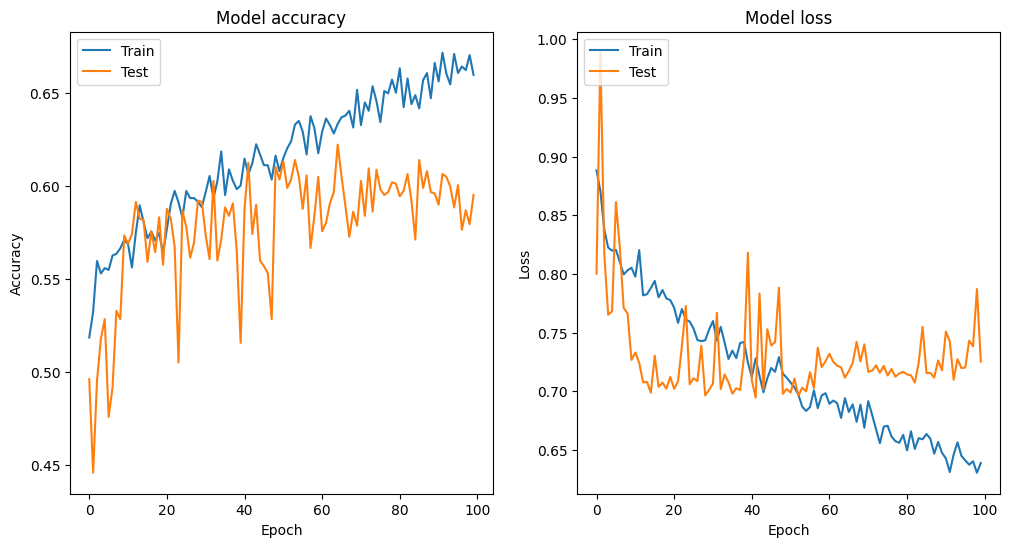

42/42 [==============================] - 1s 10ms/step


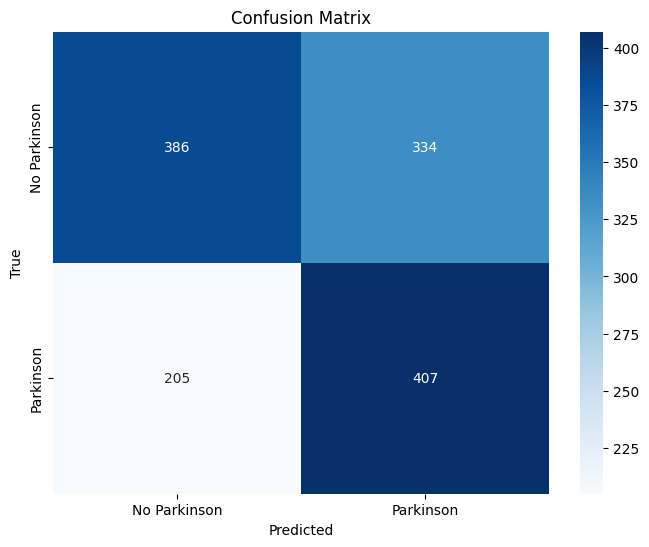

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

## Inception

### Modelos

#### Rejected

###### Picking Layers - 32 bsize - 100 epochs - Primer Expermiento - 55.86%

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained InceptionV3 model without top (fully connected layers)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Extract features from certain layers
# Choose the layers that you want to use based on the InceptionV3 architecture
# You can find the layer names by printing the summary of the InceptionV3 model
block1 = base_model.get_layer('mixed2').output
block2 = base_model.get_layer('mixed7').output
block3 = base_model.get_layer('mixed10').output

# Apply normalization
block1 = BatchNormalization()(block1)
block2 = BatchNormalization()(block2)
block3 = BatchNormalization()(block3)

# Build your own model on top
x = Flatten()(block3)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

# Compile the model and specify the optimizer, loss, and metrics
optimizer = Adam(learning_rate=0.0001)  # Adjust the learning rate
custom_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()

87910968/87910968 [==============================] - 4s 0us/step
Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_58 (Conv2D)          (None, 63, 63, 32)           864       ['input_43[0][0]']            
                                                                                                  
 batch_normalization_106 (B  (None, 63, 63, 32)           96        ['conv2d_58[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 activation (Activation)  

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
98/98 [==============================] - 25s 166ms/step - loss: 0.7612 - accuracy: 0.5589 - val_loss: 0.9591 - val_accuracy: 0.5008
Epoch 2/100
98/98 [==============================] - 12s 121ms/step - loss: 0.7007 - accuracy: 0.5824 - val_loss: 0.7946 - val_accuracy: 0.5053
Epoch 3/100
98/98 [==============================] - 12s 122ms/step - loss: 0.6877 - accuracy: 0.5972 - val_loss: 0.7278 - val_accuracy: 0.5721
Epoch 4/100
98/98 [==============================] - 12s 124ms/step - loss: 0.6746 - accuracy: 0.5959 - val_loss: 0.7219 - val_accuracy: 0.5788
Epoch 5/100
98/98 [==============================] - 12s 122ms/step - loss: 0.6834 - accuracy: 0.5869 - val_loss: 0.7418 - val_accuracy: 0.5706
Epoch 6/100
98/98 [==============================] - 12s 121ms/step - loss: 0.6639 - accuracy: 0.5997 - val_loss: 0.7485 - val_accuracy: 0.5766
Epoch 7/100
98/98 [==============================] - 12s 126ms/step - loss: 0.6682 - accuracy: 0.5959 - val_loss: 0.7436 - val_accuracy:

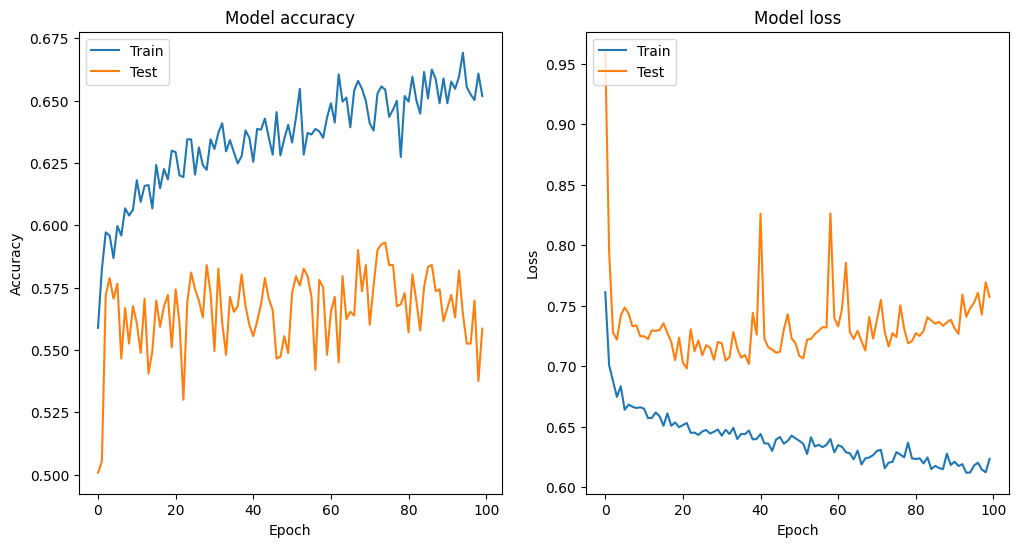

42/42 [==============================] - 2s 27ms/step


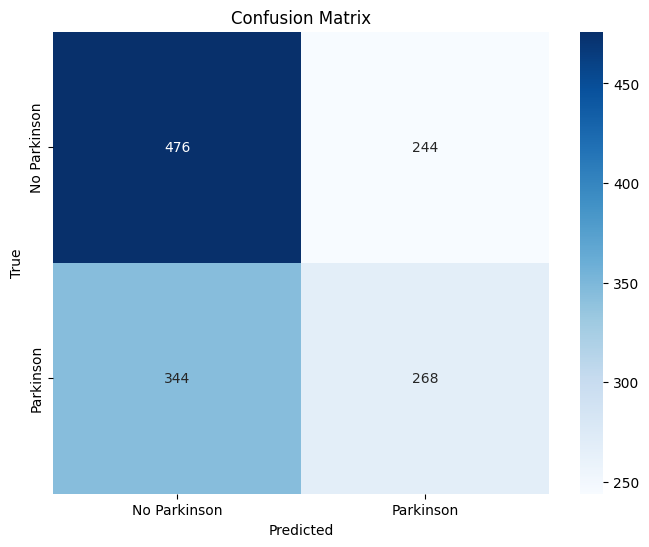

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

###### Picking Layers - 64 bsize - 100 epochs - Segundo Experimento - 66.22%

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained InceptionV3 model with top (fully connected layers)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the first few layers (adjust the number as needed)
for layer in base_model.layers[:50]:
    layer.trainable = False

# Use global average pooling instead of flatten
x = GlobalAveragePooling2D()(base_model.output)

# Add custom fully connected layers
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
custom_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_53 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_531 (Conv2D)         (None, 149, 149, 32)         864       ['input_53[0][0]']            
                                                                                                  
 batch_normalization_585 (B  (None, 149, 149, 32)         96        ['conv2d_531[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_470 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_5

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
49/49 [==============================] - 122s 2s/step - loss: 0.6860 - accuracy: 0.5775 - val_loss: 0.7358 - val_accuracy: 0.5405
Epoch 2/100
49/49 [==============================] - 62s 1s/step - loss: 0.6631 - accuracy: 0.6088 - val_loss: 0.7212 - val_accuracy: 0.5173
Epoch 3/100
49/49 [==============================] - 62s 1s/step - loss: 0.6434 - accuracy: 0.6345 - val_loss: 0.7399 - val_accuracy: 0.5495
Epoch 4/100
49/49 [==============================] - 63s 1s/step - loss: 0.6236 - accuracy: 0.6551 - val_loss: 0.7424 - val_accuracy: 0.5638
Epoch 5/100
49/49 [==============================] - 63s 1s/step - loss: 0.6097 - accuracy: 0.6467 - val_loss: 0.6936 - val_accuracy: 0.5931
Epoch 6/100
49/49 [==============================] - 63s 1s/step - loss: 0.5823 - accuracy: 0.6728 - val_loss: 0.6531 - val_accuracy: 0.6336
Epoch 7/100
49/49 [==============================] - 64s 1s/step - loss: 0.5671 - accuracy: 0.6866 - val_loss: 0.7688 - val_accuracy: 0.6186
Epoch 8/100


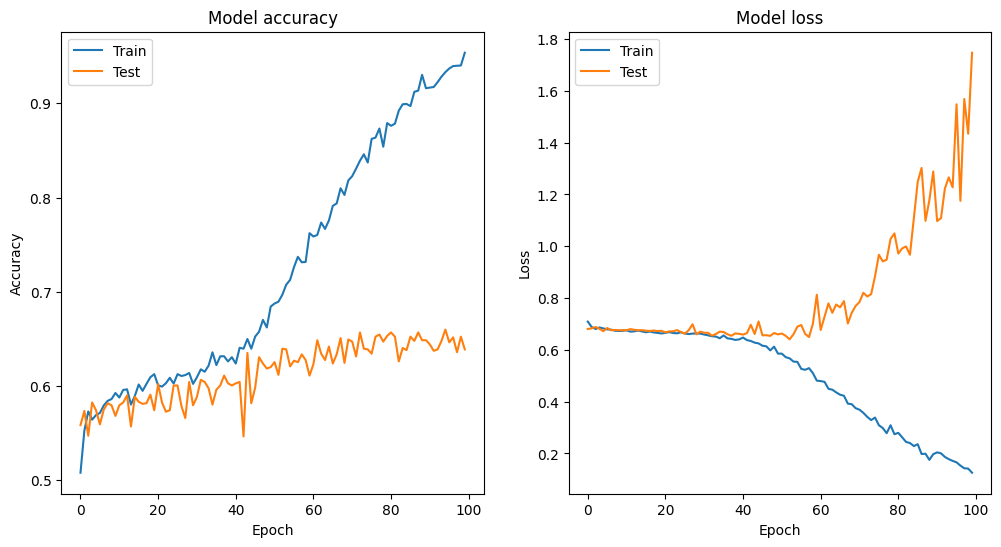

42/42 [==============================] - 5s 115ms/step


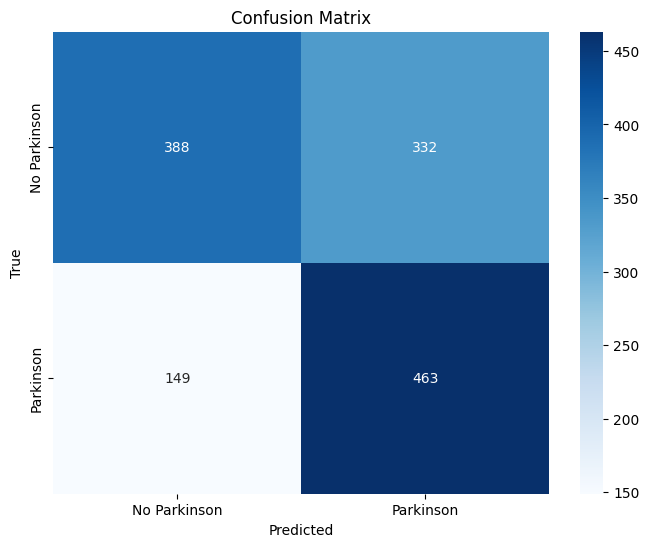

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

###### Picking Layers - 32 Batches - 100 epochs - Tercer Experimento - 62.09%

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained InceptionV3 model with top (fully connected layers)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the first 11 layers (adjust the number as needed)
for layer in base_model.layers[:11]:
    layer.trainable = False

# Use existing layers from InceptionV3
block4_conv1 = base_model.get_layer('mixed5').output
block4_conv1 = BatchNormalization()(block4_conv1)
block4_conv1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block4_conv1)
block4_conv1 = Dropout(0.1)(block4_conv1)  # Adding dropout for additional regularization

block4_conv2 = base_model.get_layer('mixed6').output
block4_conv2 = BatchNormalization()(block4_conv2)
block4_conv2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block4_conv2)
block4_conv2 = Dropout(0.2)(block4_conv2)  # Adding dropout for additional regularization

block4_conv3 = base_model.get_layer('mixed7').output
block4_conv3 = BatchNormalization()(block4_conv3)
block4_conv3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(block4_conv3)
block4_conv3 = Dropout(0.3)(block4_conv3)  # Adding dropout for additional regularization

# Continue with additional layers if needed

# Create custom fully connected layers
x = Flatten()(block4_conv3)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Adding dropout for additional regularization
output = Dense(1, activation='sigmoid')(x)

# Create a new model
custom_model = Model(inputs=base_model.input, outputs=output)

# Remove non-trainable layers from the end
while custom_model.layers and not custom_model.layers[-1].trainable:
    custom_model.layers.pop()

custom_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
custom_model.summary()


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_44 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_152 (Conv2D)         (None, 63, 63, 32)           864       ['input_44[0][0]']            
                                                                                                  
 batch_normalization_205 (B  (None, 63, 63, 32)           96        ['conv2d_152[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_94 (Activation)  (None, 63, 63, 32)           0         ['batch_normalization_2

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Now, let's train your custom model
history = custom_model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

# Evaluate the model on the test set
evaluation = custom_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')


Epoch 1/100
98/98 [==============================] - 36s 116ms/step - loss: 1.1184 - accuracy: 0.5058 - val_loss: 0.7815 - val_accuracy: 0.5225
Epoch 2/100
98/98 [==============================] - 8s 86ms/step - loss: 1.0263 - accuracy: 0.5499 - val_loss: 0.7875 - val_accuracy: 0.5435
Epoch 3/100
98/98 [==============================] - 8s 86ms/step - loss: 0.9544 - accuracy: 0.5756 - val_loss: 0.8004 - val_accuracy: 0.5601
Epoch 4/100
98/98 [==============================] - 8s 86ms/step - loss: 0.9698 - accuracy: 0.5795 - val_loss: 0.8474 - val_accuracy: 0.5878
Epoch 5/100
98/98 [==============================] - 8s 85ms/step - loss: 0.8835 - accuracy: 0.6149 - val_loss: 0.8034 - val_accuracy: 0.5938
Epoch 6/100
98/98 [==============================] - 8s 84ms/step - loss: 0.8642 - accuracy: 0.6007 - val_loss: 0.8418 - val_accuracy: 0.5721
Epoch 7/100
98/98 [==============================] - 8s 84ms/step - loss: 0.8203 - accuracy: 0.6313 - val_loss: 0.8626 - val_accuracy: 0.5893
Epoc

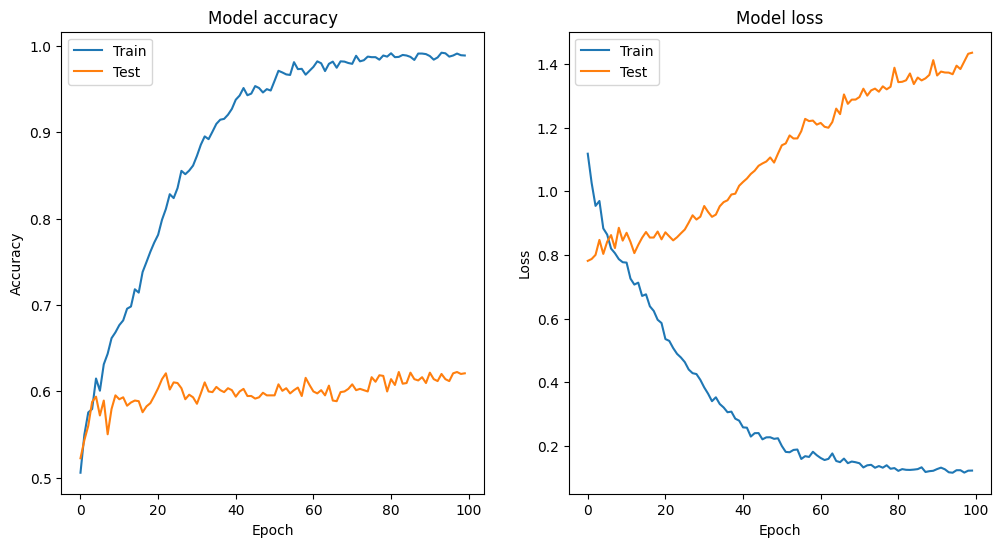

42/42 [==============================] - 2s 23ms/step


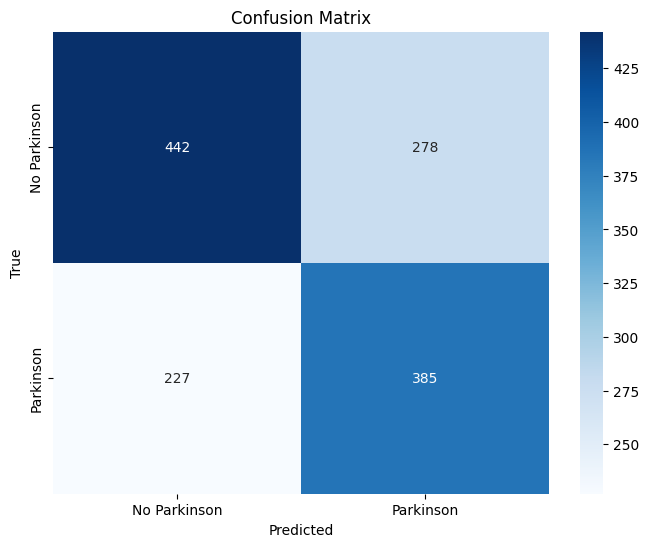

In [ ]:
plot_loss_acc(history)
con_matrix(custom_model, x_test, y_test)

#### Best

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)

# Load the InceptionV3 model without the top (fully connected) layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = True

# Create a simpler model initially
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=1e-4)

# Recompile the model after unfreezing
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation with reduced intensity
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the simpler model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[lr_reduce]
)



87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/100
195/195 [==============================] - 56s 113ms/step - loss: 0.7152 - accuracy: 0.5347 - val_loss: 9.9127 - val_accuracy: 0.5405 - lr: 1.0000e-04
Epoch 2/100
195/195 [==============================] - 13s 67ms/step - loss: 0.6824 - accuracy: 0.5753 - val_loss: 1.0276 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
195/195 [==============================] - 13s 67ms/step - loss: 0.6701 - accuracy: 0.6094 - val_loss: 0.7277 - val_accuracy: 0.4842 - lr: 1.0000e-04
Epoch 4/100
195/195 [==============================] - 13s 68ms/step - loss: 0.6591 - accuracy: 0.6171 - val_loss: 0.7084 - val_accuracy: 0.5413 - lr: 1.0000e-04
Epoch 5/100
195/195 [==============================] - 13s 68ms/step - loss: 0.6368 - accuracy: 0.6345 - val_loss: 0.7670 - val_accuracy: 0.4632 - lr: 1.0000e-04
Epoch 6/100
195/195 [==============================] - 13s 68ms/step - loss: 0.6106 - accuracy: 0.6528 - val_loss: 0.7052 - 

In [ ]:
# Evalua el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

42/42 [==============================] - 1s 29ms/step - loss: 1.5345 - accuracy: 0.6742
Test accuracy: 0.6741741895675659


In [ ]:
import plotly.graph_objects as go

# Crear figuras interactivas para la precisión y la pérdida
fig_accuracy = go.Figure()
fig_loss = go.Figure()

# Agregar trazas para la precisión en entrenamiento y validación
fig_accuracy.add_trace(go.Scatter(x=list(range(len(history.history['accuracy']))),
                                   y=history.history['accuracy'],
                                   mode='lines',
                                   name='Precisión en entrenamiento'))
fig_accuracy.add_trace(go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                                   y=history.history['val_accuracy'],
                                   mode='lines',
                                   name='Precisión en validación'))

# Configurar el diseño de la figura de precisión
fig_accuracy.update_layout(title='Precisión del modelo',
                           xaxis_title='Épocas',
                           yaxis_title='Precisión')

# Agregar trazas para la pérdida en entrenamiento y validación
fig_loss.add_trace(go.Scatter(x=list(range(len(history.history['loss']))),
                               y=history.history['loss'],
                               mode='lines',
                               name='Pérdida en entrenamiento'))
fig_loss.add_trace(go.Scatter(x=list(range(len(history.history['val_loss']))),
                               y=history.history['val_loss'],
                               mode='lines',
                               name='Pérdida en validación'))

# Configurar el diseño de la figura de pérdida
fig_loss.update_layout(title='Pérdida del modelo',
                       xaxis_title='Épocas',
                       yaxis_title='Pérdida')

# Mostrar las figuras interactivas
fig_accuracy.show()
fig_loss.show()

42/42 [==============================] - 2s 25ms/step


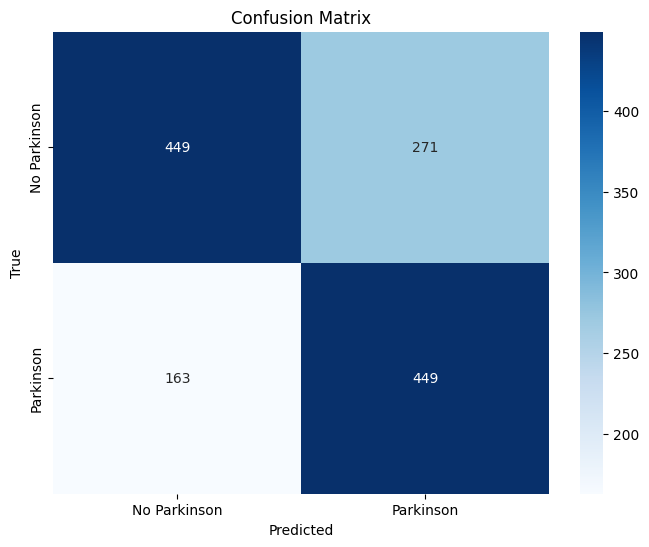

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


class_labels = ['No Parkinson', 'Parkinson']

# Predict the classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).flatten()  # Convert probabilities to binary predictions
y_true_classes = np.round(y_test).flatten()  # Convert one-hot encoded true labels to binary

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))

# Use class_labels for xticklabels and yticklabels
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



## Vision Transformer

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Definición de la capa para extraer parches de la imagen
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        # Calculate the number of patches in height and width
        num_patches_height = height // self.patch_size
        num_patches_width = width // self.patch_size

        # print(f"batch_size: {batch_size}, num_patches_height: {num_patches_height}, num_patches_width: {num_patches_width}")

        # Extract patches from the image
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )

        # Reshape the patches tensor
        patch_dims = patches.shape[-1]
        # print(f"patch_dims: {patch_dims}")
        # print(f"patches shape before reshape: {patches.shape}")

        # Specify patch_dims explicitly
        patch_dims = 768  # Update this with the actual value

        patches = tf.reshape(patches, [batch_size, num_patches_height, num_patches_width, patch_dims])
        # print(f"patches shape after reshape: {patches.shape}")
        return patches

# Definición de la capa para codificar los parches
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches

        # Capa de proyección lineal
        self.projection = layers.Dense(units=projection_dim)

        # Cambiamos la capa de posición para incorporar información espacial
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        # Generar posiciones para los parches
        positions = tf.range(start=0, limit=tf.shape(patch)[1], delta=1)

        # Aplicar proyección y agregar la información de posición
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


# Función para crear el modelo Vision Transformer (ViT)
def create_vit_classifier(input_shape=(128, 128, 3), num_classes=2):
    patch_size = 16  # Tamaño de cada parche (16x16)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    projection_dim = 256  # Adjust based on experimentation
    num_heads = 8  # Experiment with different numbers of heads
    transformer_units = [projection_dim * 2, projection_dim]
    transformer_layers = 8  # Experiment with different numbers of layers
    mlp_head_units = [512, 256]  # Adjust based on experimentation

    # Capa de entrada
    inputs = layers.Input(shape=input_shape)

    # Capa para extraer parches de la imagen
    patches = Patches(patch_size)(inputs)

    # Capa para codificar los parches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Crear múltiples capas del Transformer
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Atención multi-cabeza
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # Capas feedforward
        x3 = layers.Dense(transformer_units[0], activation=tf.nn.gelu)(x3)
        x3 = layers.Dense(transformer_units[1])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Representación para el clasificador
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Capas de la cabeza MLP para clasificación
    features = layers.Dense(mlp_head_units[0], activation=tf.nn.gelu)(representation)
    features = layers.Dropout(0.5)(features)
    features = layers.Dense(mlp_head_units[1], activation=tf.nn.gelu)(features)

    # Capa de salida para las clases
    logits = layers.Dense(num_classes)(features)

    # Crear el modelo
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



In [ ]:
model = create_vit_classifier(input_shape=(128, 128, 3), num_classes=2)

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

# Define data augmentation using ImageDataGenerator
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),  # Use your actual training data
    epochs=100,
    validation_data=(x_test, y_test)
)

Epoch 1/100
98/98 [==============================] - 40s 183ms/step - loss: 1.0641 - accuracy: 0.4916 - val_loss: 0.7102 - val_accuracy: 0.4595
Epoch 2/100
98/98 [==============================] - 16s 163ms/step - loss: 0.7517 - accuracy: 0.5171 - val_loss: 0.6953 - val_accuracy: 0.4595
Epoch 3/100
98/98 [==============================] - 16s 161ms/step - loss: 0.7253 - accuracy: 0.5100 - val_loss: 0.7141 - val_accuracy: 0.4595
Epoch 4/100
98/98 [==============================] - 16s 160ms/step - loss: 0.7057 - accuracy: 0.4903 - val_loss: 0.6974 - val_accuracy: 0.4595
Epoch 5/100
98/98 [==============================] - 16s 160ms/step - loss: 0.6987 - accuracy: 0.5212 - val_loss: 0.7008 - val_accuracy: 0.4595
Epoch 6/100
98/98 [==============================] - 16s 160ms/step - loss: 0.6987 - accuracy: 0.4910 - val_loss: 0.6940 - val_accuracy: 0.4595
Epoch 7/100
98/98 [==============================] - 16s 161ms/step - loss: 0.6962 - accuracy: 0.5154 - val_loss: 0.6935 - val_accuracy:

42/42 [==============================] - 2s 52ms/step - loss: 0.6914 - accuracy: 0.5405
Test Accuracy: 54.05%


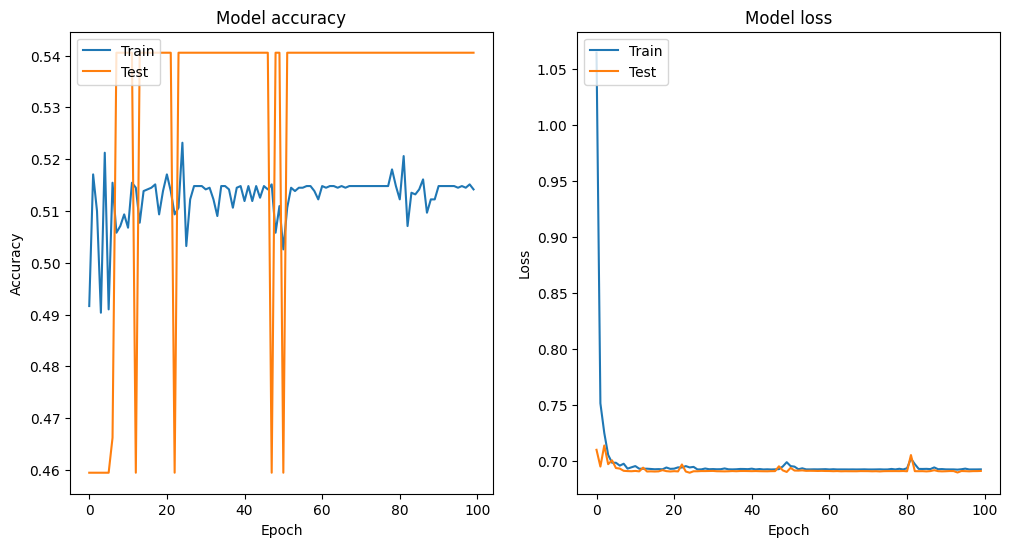

42/42 [==============================] - 2s 49ms/step


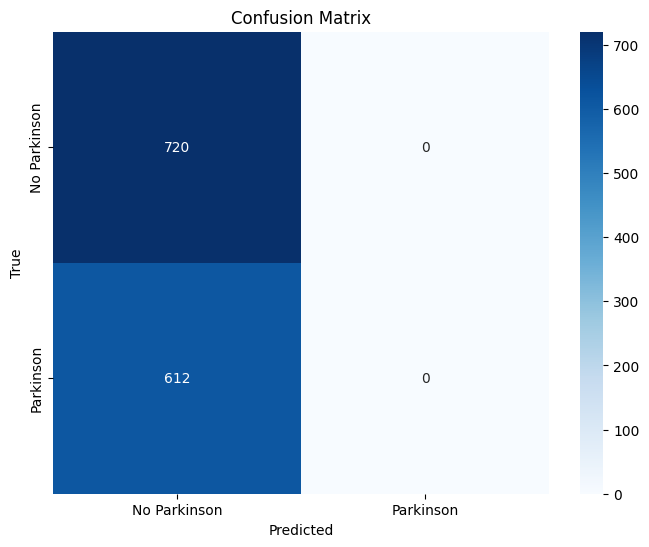

In [ ]:
# Evaluate the model on the test set
evaluation = model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')

plot_loss_acc(history)
con_matrix(model, x_test, y_test)

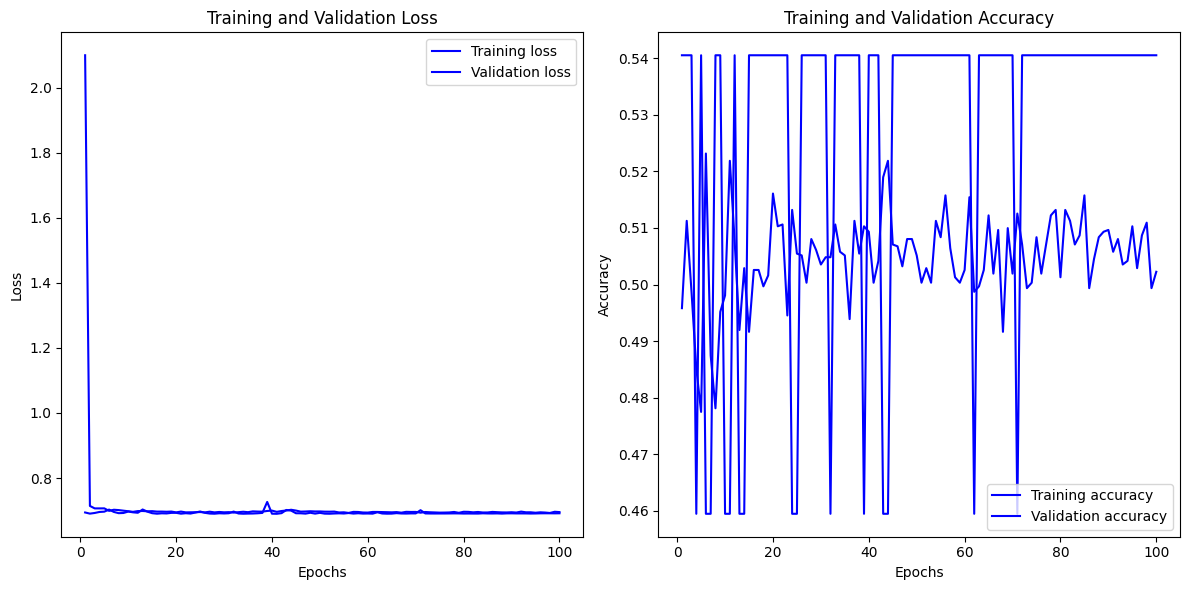

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_values, 'b', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
hc_tfrecord_filename = "/content/drive/MyDrive/pd_labels//hc_bw.tfrecord"
left_tfrecord_filename = "/content/drive/MyDrive/pd_labels//left_bw.tfrecord"
right_tfrecord_filename = "/content/drive/MyDrive/pd_labels//right_bw.tfrecord"


def apply_data_augmentation(image):
    # Randomly flip horizontally
    if np.random.rand() > 0.5:
        image = np.fliplr(image)

    # Randomly flip vertically
    if np.random.rand() > 0.5:
        image = np.flipud(image)

    # Random brightness adjustment
    brightness_factor = 0.5 + np.random.rand()  # Adjust the range as needed
    image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    return image


def build_lists(tfrecord_filename, target_size=(224, 224), is_right=False):
    images = []
    labels = []

    # Lee los datos crudos del archivo TFRecord
    raw_dataset = tf.data.TFRecordDataset(tfrecord_filename)
    for raw_record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())

        # Recupera los datos de la imagen del ejemplo
        image_bytes = example.features.feature["image"].bytes_list.value[0]
        image_np = np.frombuffer(image_bytes, dtype=np.uint8)
        image = cv2.imdecode(image_np, flags=cv2.IMREAD_GRAYSCALE)  # Cambio aquí

        # Resize the image to the target size
        image_resized = cv2.resize(image, target_size)

        # Si necesitas aplicar ZCA whitening u otras transformaciones que
        # requieren 3 canales, considera si son adecuadas para imágenes en escala de grises.
        # De lo contrario, omite esos pasos o ajustalos para un solo canal.

        # Apply additional data augmentation
        augmented_images = [image_resized]  # Original image

        if not is_right:
            for i in range(1):  # Rotate at 90, 180, and 270 degrees
                augmented_images.append(np.rot90(image_resized, k=i + 1))

        # Recupera los datos de la etiqueta (codificada en one-hot)
        label_one_hot = np.array(example.features.feature["label"].int64_list.value)

        # Agrega los datos de las imágenes y la etiqueta a sus respectivas listas
        images.extend(augmented_images)
        labels.extend([label_one_hot] * len(augmented_images))

    return [images, labels]


# Set the target size for resizing
target_size = (224, 224)  # Adjust as needed

# Convierte las listas de datos de imagen y etiqueta a matrices NumPy para el conjunto de entrenamiento
hc_images, hc_labels = build_lists(hc_tfrecord_filename, target_size)
print(len(hc_images))

# Convierte las listas de datos de imagen y etiqueta a matrices NumPy para el conjunto de prueba
left_images, left_labels = build_lists(left_tfrecord_filename, target_size)
print(len(left_images))

right_images, right_labels = build_lists(right_tfrecord_filename, target_size, True)
print(len(right_images))

2320
1200
920


In [ ]:
from sklearn.model_selection import train_test_split

# Concatenate images and labels for each class
all_images = hc_images + left_images + right_images
all_labels = hc_labels + left_labels + right_labels

# Convert lists to NumPy arrays
x_all = np.array(all_images)
y_all = np.array(all_labels)

# Split the data into training and testing sets (70% train, 30% test)
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.3, random_state=42
)

# Print the shapes of the resulting arrays
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (3108, 224, 224)
Shape of y_train: (3108, 1)
Shape of x_test: (1332, 224, 224)
Shape of y_test: (1332, 1)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


def create_vit_classifier(input_shape=(224, 224, 1), num_classes=2):
    patch_size = 16  # Tamaño de cada parche (16x16)
    num_patches = (input_shape[0] // patch_size) ** 2  # Ajustado para 128x128
    projection_dim = 64
    num_heads = 4
    transformer_units = [projection_dim * 2, projection_dim]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]

    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Crear múltiples capas del Transformer
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(transformer_units[0], activation=tf.nn.gelu)(x3)
        x3 = layers.Dense(transformer_units[1])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Representación para el clasificador
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = layers.Dense(mlp_head_units[0], activation=tf.nn.gelu)(representation)
    features = layers.Dropout(0.5)(features)
    features = layers.Dense(mlp_head_units[1], activation=tf.nn.gelu)(features)
    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model = create_vit_classifier(input_shape=(224, 224, 1), num_classes=2)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

# Asegúrate de que X_train y y_train estén preparados por tu código de preprocesamiento
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=100,
    validation_data=(x_test, y_test),
)

Epoch 1/100
49/49 [==============================] - 30s 178ms/step - loss: 1.2948 - accuracy: 0.5113 - val_loss: 0.8817 - val_accuracy: 0.5405
Epoch 2/100
49/49 [==============================] - 8s 154ms/step - loss: 0.8483 - accuracy: 0.5032 - val_loss: 0.7561 - val_accuracy: 0.4595
Epoch 3/100
49/49 [==============================] - 8s 155ms/step - loss: 0.8332 - accuracy: 0.4833 - val_loss: 0.7544 - val_accuracy: 0.5405
Epoch 4/100
49/49 [==============================] - 8s 155ms/step - loss: 0.8005 - accuracy: 0.4916 - val_loss: 0.6897 - val_accuracy: 0.5405
Epoch 5/100
49/49 [==============================] - 8s 154ms/step - loss: 0.7739 - accuracy: 0.5093 - val_loss: 0.7068 - val_accuracy: 0.5405
Epoch 6/100
49/49 [==============================] - 8s 155ms/step - loss: 0.7606 - accuracy: 0.5084 - val_loss: 0.6900 - val_accuracy: 0.5405
Epoch 7/100
49/49 [==============================] - 8s 155ms/step - loss: 0.7524 - accuracy: 0.5113 - val_loss: 0.6900 - val_accuracy: 0.540

In [ ]:
import plotly.graph_objects as go
import numpy as np

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = np.arange(1, len(loss_values) + 1)

# Crear un gráfico para la pérdida
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=epochs, y=loss_values, mode='lines', name='Training loss'))
fig_loss.add_trace(go.Scatter(x=epochs, y=val_loss_values, mode='lines', name='Validation loss'))
fig_loss.update_xaxes(title_text='Epochs')
fig_loss.update_yaxes(title_text='Loss')
fig_loss.update_layout(title_text='Training and Validation Loss',
                      xaxis=dict(showline=True, showgrid=False),
                      yaxis=dict(showline=True, showgrid=False),
                      legend=dict(orientation='h', y=1.1))

# Crear un gráfico para la precisión
fig_accuracy = go.Figure()
fig_accuracy.add_trace(go.Scatter(x=epochs, y=acc_values, mode='lines', name='Training accuracy'))
fig_accuracy.add_trace(go.Scatter(x=epochs, y=val_acc_values, mode='lines', name='Validation accuracy'))
fig_accuracy.update_xaxes(title_text='Epochs')
fig_accuracy.update_yaxes(title_text='Accuracy')
fig_accuracy.update_layout(title_text='Training and Validation Accuracy',
                          xaxis=dict(showline=True, showgrid=False),
                          yaxis=dict(showline=True, showgrid=False),
                          legend=dict(orientation='h', y=1.1))

# Ajustar el espaciado y mostrar los gráficos
fig_loss.update_layout(height=400, width=600, margin=dict(t=60, r=20, b=40, l=20))
fig_accuracy.update_layout(height=400, width=600, margin=dict(t=60, r=20, b=40, l=20))

fig_loss.show()
fig_accuracy.show()
